<a href="https://colab.research.google.com/github/NerminHussein/HR-Analytics_Classifier/blob/main/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HR Analytics**








# **Problem Statement**

A random large company, employs at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons -

The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
A sizeable department has to be maintained, for the purposes of recruiting new talent
More often than not, the new employees have to be trained for the job and/or given time to acclimatise themselves to the company
Hence, the management has contracted an HR analytics firm to understand what factors they should focus on, in order to curb attrition. In other words, they want to know what changes they should make to their workplace, in order to get most of their employees to stay. Also, they want to know which of these variables is most important and needs to be addressed right away.

Since you are one of the star analysts at the firm, this project has been given to you.

Goal of the case study
You are required to model the probability of attrition using a logistic regression. The results thus obtained will be used by the management to understand what changes they should make to their workplace, in order to get most of their employees to stay.




In [ ]:
# Getting the model ready by importing the libraries that will be used
import pandas as pd                          # Dealing with Dataframes
import numpy as np                           # Dealing with Numpy Arrays
import glob
import os
from datetime import datetime,timedelta
import matplotlib.pyplot as plt             # matplotlib is used for ploting graphs
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,recall_score,f1_score,precision_score
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import resample
from imblearn import under_sampling ,over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Time Analysis

In [ ]:
log_in=pd.read_csv('in_time.csv')
log_out=pd.read_csv('out_time.csv')
# Finding the columns where it contains only null values which indicates it being a day off for the company 
#Doing that for the log in Dataframe
for columnName,columnValue in log_in.iteritems():
  nu=columnValue.isnull().sum()
  if nu==len(log_in):
    log_in.drop([columnName],axis=1,inplace=True)
#Doing the same for logout Dataframe
for columnName,columnValue in log_out.iteritems():
  nu=columnValue.isnull().sum()
  if nu==len(log_out):
    log_out.drop([columnName],axis=1,inplace=True)
#Making sure the remaining null values are equal in both Dataframes
#This could indicate day off for the employees
nu_in=sum(log_in.isnull().sum())
nu_out=sum(log_out.isnull().sum())
print(nu_in==nu_out)

True


In [ ]:
#Filling the null values with 0 to compre them later
log_in.replace(np.nan, 0)
log_out.replace(np.nan, 0)
#Comparing values from same column and index and if they match it will be replaced with null values
comp_df=log_in.compare(log_out,keep_shape=True)
#
nu_comp=(sum(comp_df.isnull().sum())/2)-len(log_in)
print(nu_comp==nu_in)


True


In [ ]:
#Defining some parameters
work_hours_list=[]
day_off_lis=[]
g=1
#Iterating through each row in both dataframes at the same time
for (idx,s1),(_,s2) in zip(log_in.iterrows(),log_out.iterrows()):
  lis=[]
  x=0
#Iterating through each value in that row
  for (id,v1),(_,v2) in zip(s1.iteritems(),s2.iteritems()):
#Dividing the time format into date and time and calculating time difference to assess hours worked
    a=str(v1).split()
    b=str(v2).split()
    if len(a)==2:
      c=datetime.strptime(a[1],'%H:%M:%S')
      d=datetime.strptime(b[1],'%H:%M:%S')
      tmdf=d-c
      tmdh=timedelta.total_seconds(tmdf)/3600
      lis.append(float(tmdh))
    else:
      x+=1
#Creating two lists one holding average hours worked pe year for each employee and the other holding number of days off
  mea=sum(lis)/len(lis)
  work_hours_list.append(mea)
  day_off_lis.append(x-1)
  g+=1
#Getting a new Dataframe from the Dictionary
dic={'Average hours worked':work_hours_list,'Days off':day_off_lis}
work_hours=pd.DataFrame(dic)



In [ ]:
#Adding an employee ID column to merge this data with the other dataframes
work_hours['EmployeeID']=work_hours.index+1
emp=work_hours.pop('EmployeeID')
work_hours.insert(0,'EmployeeID',emp)


# Pre-processing

In [ ]:
employee_survey_data=pd.read_csv('employee_survey_data.csv')
print(employee_survey_data.isnull().sum())


EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64


In [ ]:
# Summary of Data
print(employee_survey_data.describe())

        EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.250000                 2.000000         2.000000         2.000000
50%    2205.500000                 3.000000         3.000000         3.000000
75%    3307.750000                 4.000000         4.000000         3.000000
max    4410.000000                 4.000000         4.000000         4.000000


In [ ]:
print("Mean-----------------------------------------")
print(employee_survey_data.mean())
#mean       
#EnvironmentSatisfaction       2.723603 
#JobSatisfaction               2.728246
#WorkLifeBalance               2.761436
print("Median-----------------------------------------")
print(employee_survey_data.median())
# Median
#EnvironmentSatisfaction       3.0
#JobSatisfaction               3.0
#WorkLifeBalance               3.0

# Mean & Median Approximatery same so we choose Median to Fill the NAN Data

Mean-----------------------------------------
EmployeeID                 2205.500000
EnvironmentSatisfaction       2.723603
JobSatisfaction               2.728246
WorkLifeBalance               2.761436
dtype: float64
Median-----------------------------------------
EmployeeID                 2205.5
EnvironmentSatisfaction       3.0
JobSatisfaction               3.0
WorkLifeBalance               3.0
dtype: float64


In [ ]:
#Fill Null in column of EnvironmentSatisfaction with Median
employee_survey_data['EnvironmentSatisfaction'] = employee_survey_data['EnvironmentSatisfaction'].fillna(employee_survey_data['EnvironmentSatisfaction'].median())

In [ ]:
#Fill Null in column of JobSatisfaction with Median
employee_survey_data['JobSatisfaction'] = employee_survey_data['JobSatisfaction'].fillna(employee_survey_data['JobSatisfaction'].median())

In [ ]:
#Fill Null in column of WorkLifeBalance with Median
employee_survey_data['WorkLifeBalance'] = employee_survey_data['WorkLifeBalance'].fillna(employee_survey_data['WorkLifeBalance'].median())

In [ ]:
#check if found NULL Values in employee_survey_data file 
print(employee_survey_data.isnull().sum())

EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64


In [ ]:
Manager_survey_data=pd.read_csv('manager_survey_data.csv')
print(Manager_survey_data.isnull().sum())

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64


In [ ]:
General_Data=pd.read_csv('general_data.csv')
print(General_Data.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


In [ ]:
print("Mean-----------------------------------------")
print(General_Data.mean())
#################################################
print("Median-----------------------------------------")
print(General_Data.median())

Mean-----------------------------------------
Age                           36.923810
DistanceFromHome               9.192517
Education                      2.912925
EmployeeCount                  1.000000
EmployeeID                  2205.500000
JobLevel                       2.063946
MonthlyIncome              65029.312925
NumCompaniesWorked             2.694830
PercentSalaryHike             15.209524
StandardHours                  8.000000
StockOptionLevel               0.793878
TotalWorkingYears             11.279936
TrainingTimesLastYear          2.799320
YearsAtCompany                 7.008163
YearsSinceLastPromotion        2.187755
YearsWithCurrManager           4.123129
dtype: float64
Median-----------------------------------------
Age                           36.0
DistanceFromHome               7.0
Education                      3.0
EmployeeCount                  1.0
EmployeeID                  2205.5
JobLevel                       2.0
MonthlyIncome              49190.0
NumCom

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [ ]:
# Filling null values
General_Data['NumCompaniesWorked'] = General_Data['NumCompaniesWorked'].fillna(General_Data['NumCompaniesWorked'].mean())

In [ ]:
# Filling null values
General_Data['TotalWorkingYears'] = General_Data['TotalWorkingYears'].fillna(General_Data['TotalWorkingYears'].mean())

In [ ]:
# Making sure no nulls exists after filling them
print(General_Data.isnull().sum())

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


In [ ]:
#Merging
Merge_Employee_Manager=employee_survey_data.merge(Manager_survey_data, on='EmployeeID')

In [ ]:
#Merging
Merge_EM_Data=Merge_Employee_Manager.merge(General_Data, on='EmployeeID')

In [ ]:
# Making sure no nulls exists in the new merge
print(Merge_EM_Data.isnull().sum())

EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


In [ ]:
#Merging
Merge_WH_ALLData=Merge_EM_Data.merge(work_hours, on='EmployeeID')
Merge_WH_ALLData.shape

(4410, 31)

In [ ]:
#Understanding type of data and making sure it is logical
Merge_WH_ALLData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4410 non-null   float64
 2   JobSatisfaction          4410 non-null   float64
 3   WorkLifeBalance          4410 non-null   float64
 4   JobInvolvement           4410 non-null   int64  
 5   PerformanceRating        4410 non-null   int64  
 6   Age                      4410 non-null   int64  
 7   Attrition                4410 non-null   object 
 8   BusinessTravel           4410 non-null   object 
 9   Department               4410 non-null   object 
 10  DistanceFromHome         4410 non-null   int64  
 11  Education                4410 non-null   int64  
 12  EducationField           4410 non-null   object 
 13  EmployeeCount            4410 non-null   int64  
 14  Gender                  

In [ ]:
#Showing Final Data after merge
Merge_WH_ALLData.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,BusinessTravel,Department,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Average hours worked,Days off,Deserve a Promotion,Got the Promotion,Is Loyal,increase_Salary,Work in Field
0,1,3.0,4.0,2.0,3,3,51,0,Travel_Rarely,Sales,...,1,0,0,7.373651,17,0,0,1,1,1
1,2,3.0,2.0,4.0,2,4,31,1,Travel_Frequently,Research & Development,...,5,1,4,7.718969,13,1,1,1,0,0
2,3,2.0,2.0,1.0,3,3,32,0,Travel_Frequently,Research & Development,...,5,0,3,7.013240,7,1,1,1,0,0
3,4,4.0,4.0,3.0,2,3,38,0,Non-Travel,Research & Development,...,8,7,5,7.193678,14,1,2,0,1,0
4,5,4.0,1.0,3.0,3,3,32,0,Travel_Rarely,Research & Development,...,6,0,4,8.006175,4,1,1,0,0,0


# Explanatory Analysis

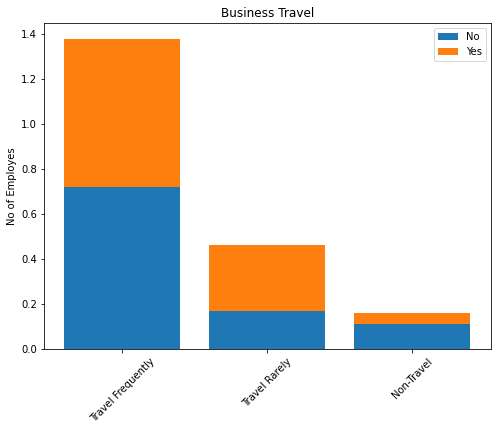

In [ ]:
a=list(Merge_WH_ALLData.BusinessTravel[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))

a=list(Merge_WH_ALLData.BusinessTravel[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))
labels=['Travel Frequently','Travel Rarely','Non-Travel']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Business Travel')
plt.xticks(rotation = 45)
ax.legend()

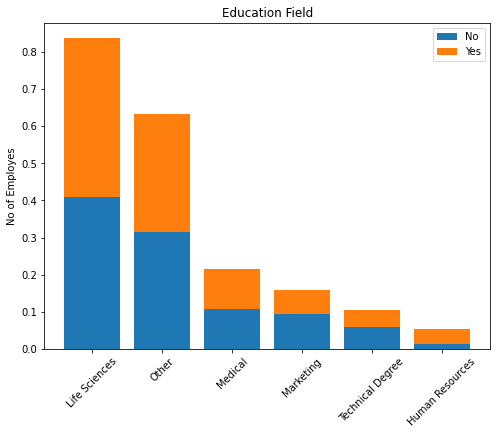

In [ ]:
a=list(Merge_WH_ALLData.EducationField[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.EducationField[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.EducationField.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Education Field')
plt.xticks(rotation = 45)
ax.legend()

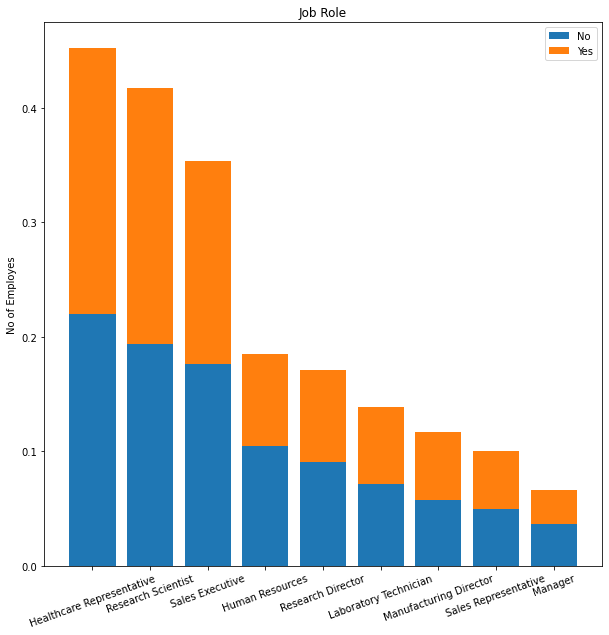

In [ ]:
a=list(Merge_WH_ALLData.JobRole[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.JobRole[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.JobRole.unique())
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Job Role')
plt.xticks(rotation = 20)
ax.legend()

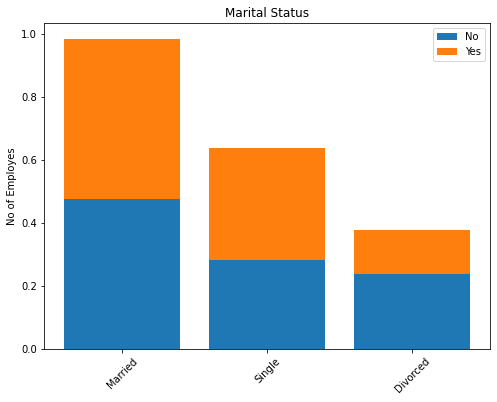

In [ ]:
a=list(Merge_WH_ALLData.MaritalStatus[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.MaritalStatus[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.MaritalStatus.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Marital Status')
plt.xticks(rotation = 45)
ax.legend()

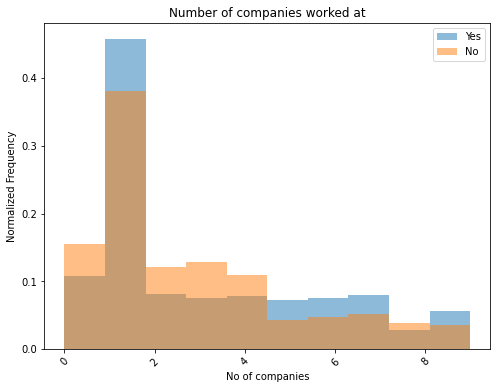

In [ ]:
a=list(Merge_WH_ALLData.NumCompaniesWorked[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.NumCompaniesWorked[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=10,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=10,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Number of companies worked at')
ax.set_xlabel('No of companies')
plt.xticks(rotation = 45)
ax.legend()


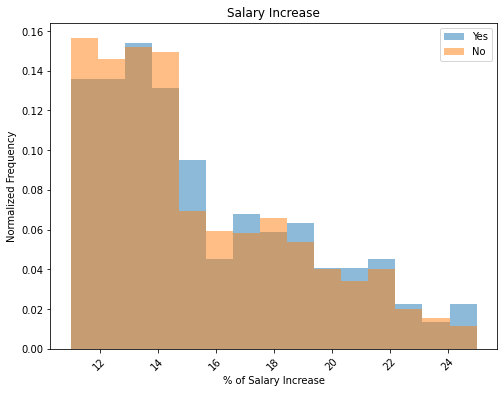

In [ ]:
a=list(Merge_WH_ALLData.PercentSalaryHike[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.PercentSalaryHike[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Salary Increase')
ax.set_xlabel('% of Salary Increase')
plt.xticks(rotation = 45)
ax.legend()

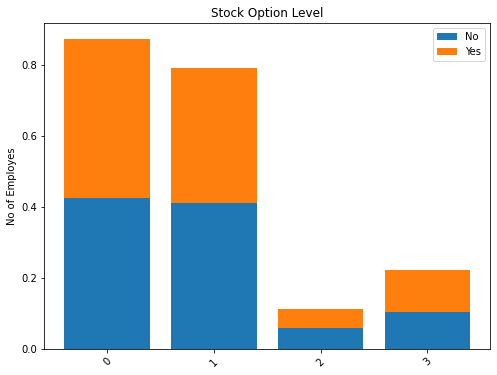

In [ ]:
######
a=list(Merge_WH_ALLData.StockOptionLevel[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.StockOptionLevel[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.StockOptionLevel.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Stock Option Level')
ax.set_xticks([0,1,2,3])
plt.xticks(rotation = 45)
ax.legend()

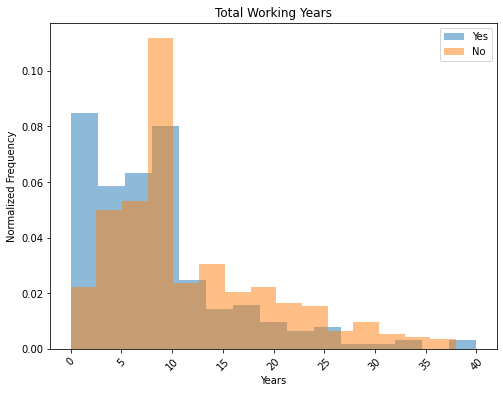

In [ ]:
a=list(Merge_WH_ALLData.TotalWorkingYears[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.TotalWorkingYears[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Total Working Years')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
ax.legend()

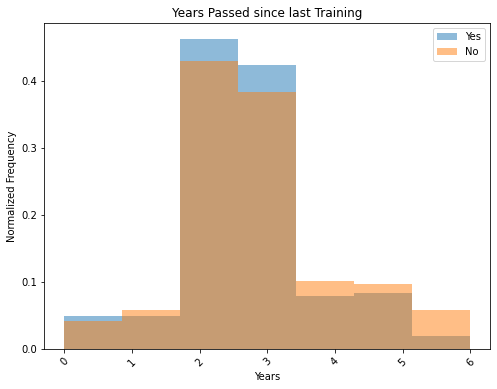

In [ ]:
a=list(Merge_WH_ALLData.TrainingTimesLastYear[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.TrainingTimesLastYear[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=7,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=7,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Years Passed since last Training')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
ax.legend()

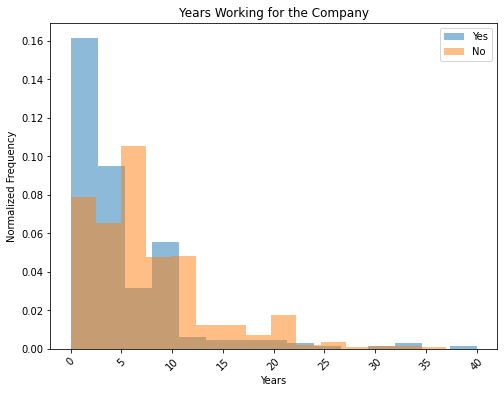

In [ ]:
a=list(Merge_WH_ALLData.YearsAtCompany[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.YearsAtCompany[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Years Working for the Company')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
ax.legend()

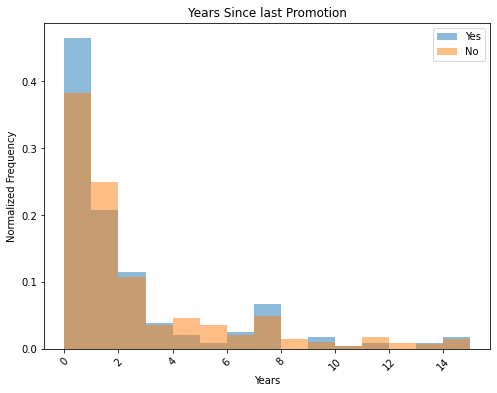

In [ ]:
a=list(Merge_WH_ALLData.YearsSinceLastPromotion[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.YearsSinceLastPromotion[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Years Since last Promotion')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
ax.legend()

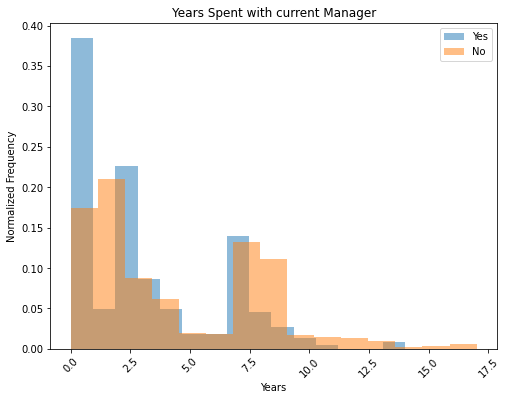

In [ ]:
a=list(Merge_WH_ALLData.YearsWithCurrManager[Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData.YearsWithCurrManager[Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Years Spent with current Manager')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
plt.legend()

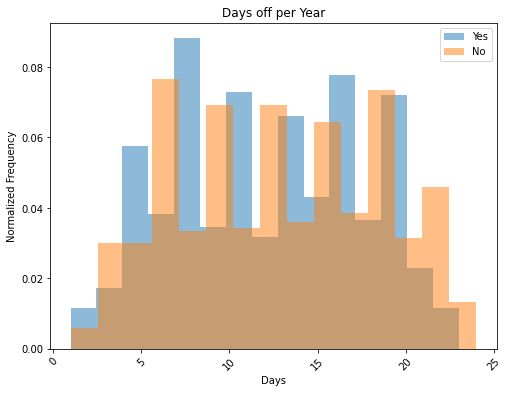

In [ ]:
a=list(Merge_WH_ALLData['Days off'][Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData['Days off'][Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Days off per Year')
ax.set_xlabel('Days')
plt.xticks(rotation = 45)
ax.legend()

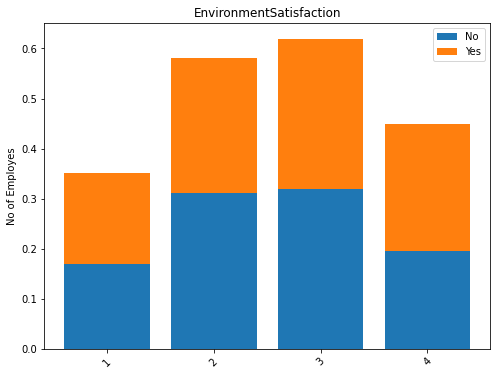

In [ ]:

######
a=list(Merge_WH_ALLData.EnvironmentSatisfaction[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.EnvironmentSatisfaction[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.EnvironmentSatisfaction.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('EnvironmentSatisfaction')
ax.set_xticks([1,2,3,4])
plt.xticks(rotation = 45)
ax.legend()

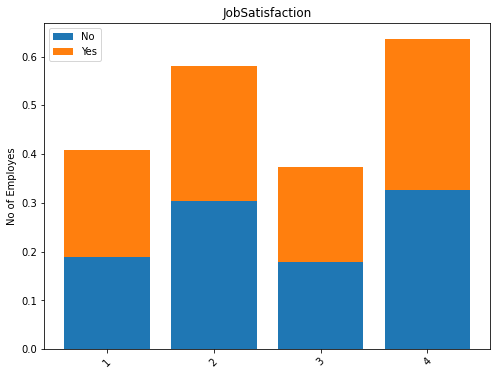

In [ ]:
 

######
a=list(Merge_WH_ALLData.JobSatisfaction[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.JobSatisfaction[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.JobSatisfaction.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('JobSatisfaction')
ax.set_xticks([1,2,3,4])
plt.xticks(rotation = 45)
ax.legend()


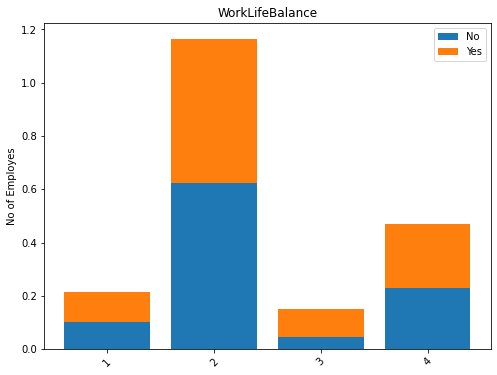

In [ ]:
a=list(Merge_WH_ALLData.WorkLifeBalance[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.WorkLifeBalance[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.WorkLifeBalance.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('WorkLifeBalance')
ax.set_xticks([1,2,3,4])
plt.xticks(rotation = 45)
ax.legend()

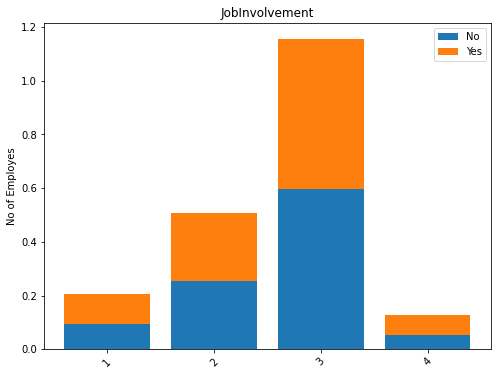

In [ ]:
a=list(Merge_WH_ALLData.JobInvolvement[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.JobInvolvement[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.JobInvolvement.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('JobInvolvement')
ax.set_xticks([1,2,3,4])
plt.xticks(rotation = 45)
ax.legend()

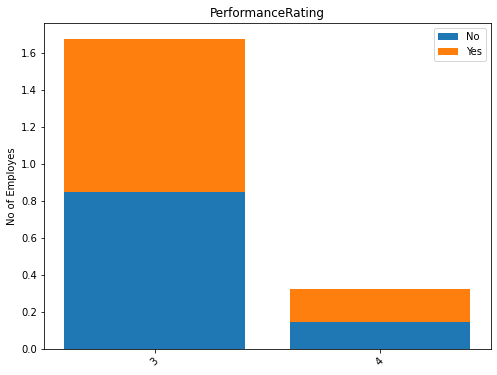

In [ ]:

a=list(Merge_WH_ALLData.PerformanceRating[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.PerformanceRating[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.PerformanceRating.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('PerformanceRating')
ax.set_xticks([3,4])
plt.xticks(rotation = 45)
ax.legend()

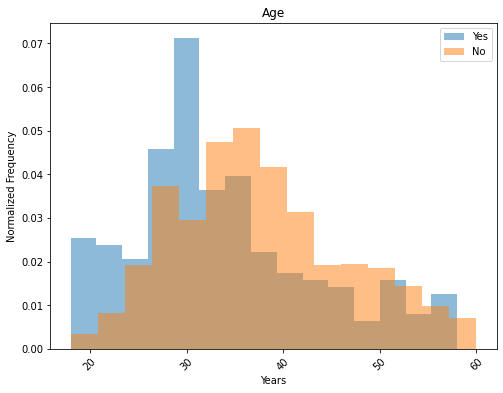

In [ ]:
a=list(Merge_WH_ALLData['Age'][Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData['Age'][Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Age')
ax.set_xlabel('Years')
plt.xticks(rotation = 45)
ax.legend()

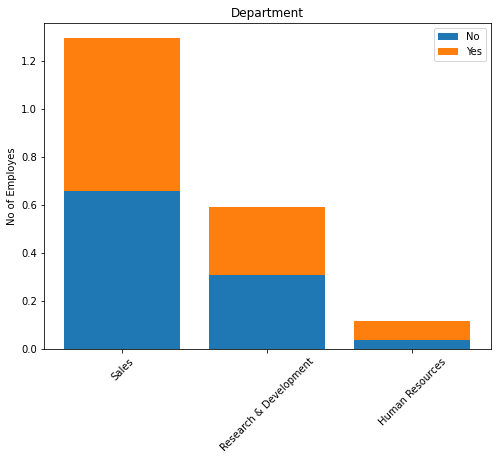

In [ ]:
 
a=list(Merge_WH_ALLData.Department[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.Department[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.Department.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Department')

plt.xticks(rotation = 45)
ax.legend()

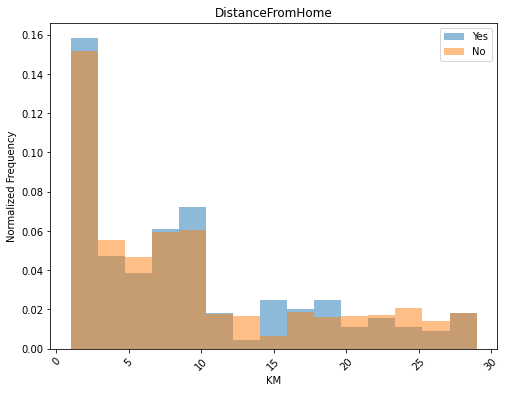

In [ ]:
a=list(Merge_WH_ALLData['DistanceFromHome'][Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData['DistanceFromHome'][Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('DistanceFromHome')
ax.set_xlabel('KM')
plt.xticks(rotation = 45)
ax.legend()

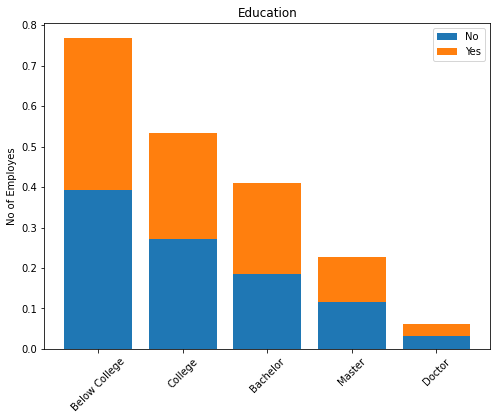

In [ ]:

a=list(Merge_WH_ALLData.Education[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.Education[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=['Below College','College','Bachelor','Master','Doctor']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Education')
plt.xticks(rotation = 45)
ax.legend()

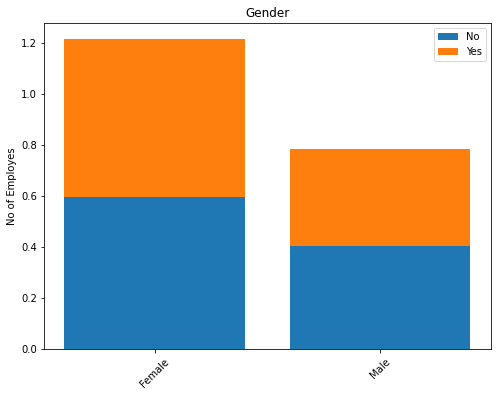

In [ ]:

a=list(Merge_WH_ALLData.Gender[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.Gender[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.Gender.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('Gender')

plt.xticks(rotation = 45)
ax.legend()

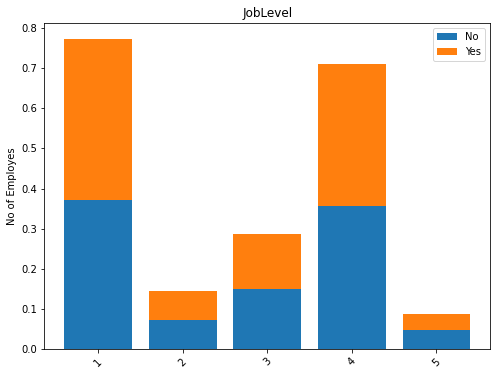

In [ ]:


a=list(Merge_WH_ALLData.JobLevel[Merge_WH_ALLData.Attrition=='Yes'].value_counts())
atrr_yes=[]
for i in a:
  atrr_yes.append(i/sum(a))
a=list(Merge_WH_ALLData.JobLevel[Merge_WH_ALLData.Attrition=='No'].value_counts())
attr_no=[]
for i in a:
  attr_no.append(i/sum(a))

labels=list(Merge_WH_ALLData.JobLevel.unique())
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.bar(labels,attr_no,label='No')
ax.bar(labels,atrr_yes,label='Yes',bottom=attr_no)
ax.set_ylabel('No of Employes')
ax.set_title('JobLevel')
# ax.set_xticks([])
plt.xticks(rotation = 45)
ax.legend()

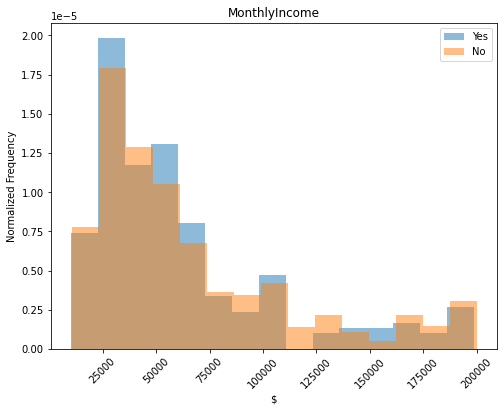

In [ ]:
a=list(Merge_WH_ALLData['MonthlyIncome'][Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData['MonthlyIncome'][Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('MonthlyIncome')
ax.set_xlabel('$')
plt.xticks(rotation = 45)
ax.legend()

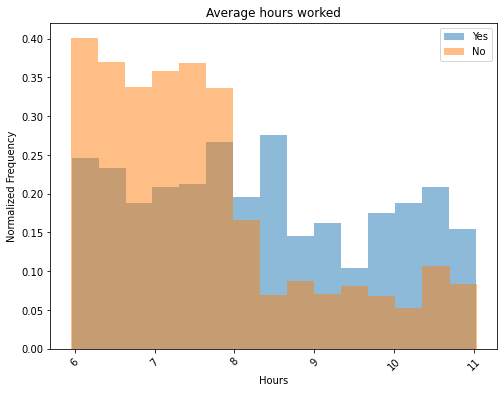

In [ ]:
a=list(Merge_WH_ALLData['Average hours worked'][Merge_WH_ALLData.Attrition=='Yes'])
atrr_yes=a
a=list(Merge_WH_ALLData['Average hours worked'][Merge_WH_ALLData.Attrition=='No'])
attr_no=a
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(x=atrr_yes,alpha=0.5,bins=15,density=True,label='Yes')
ax.hist(x=attr_no,alpha=0.5,bins=15,density=True,label='No')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Average hours worked')
ax.set_xlabel('Hours')
plt.xticks(rotation = 45)
ax.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


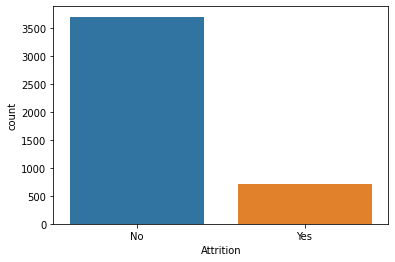

In [ ]:
sns.countplot(Merge_WH_ALLData['Attrition'])  # so the Data Imbalance Data we try to solve the problem using Resample

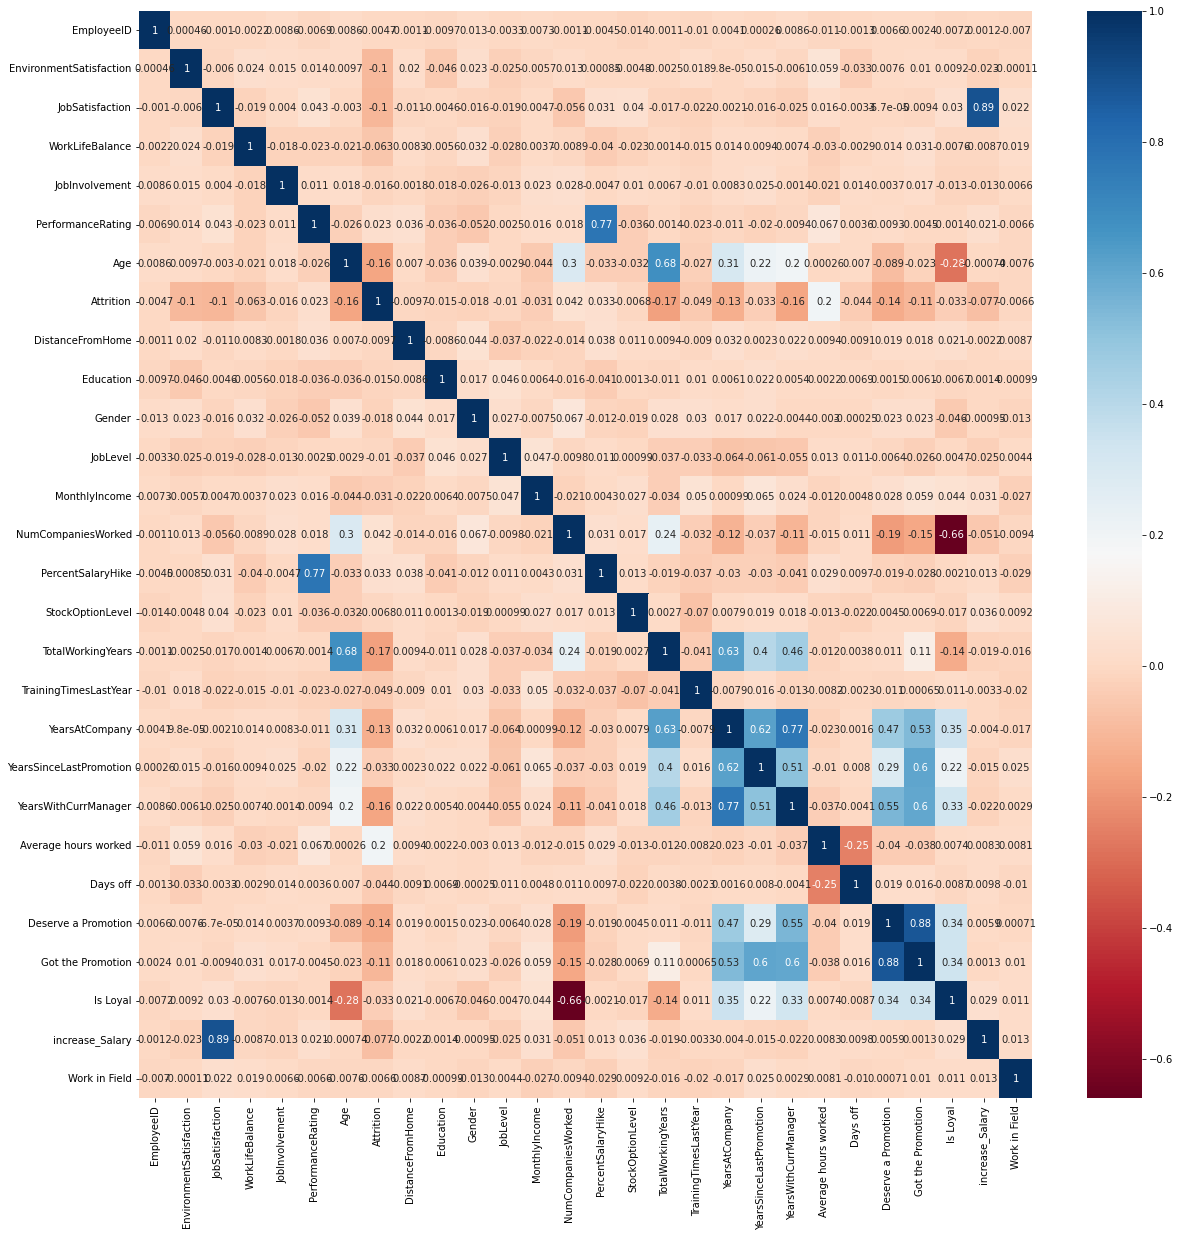

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(Merge_WH_ALLData.corr(), annot = True, cmap="RdBu");

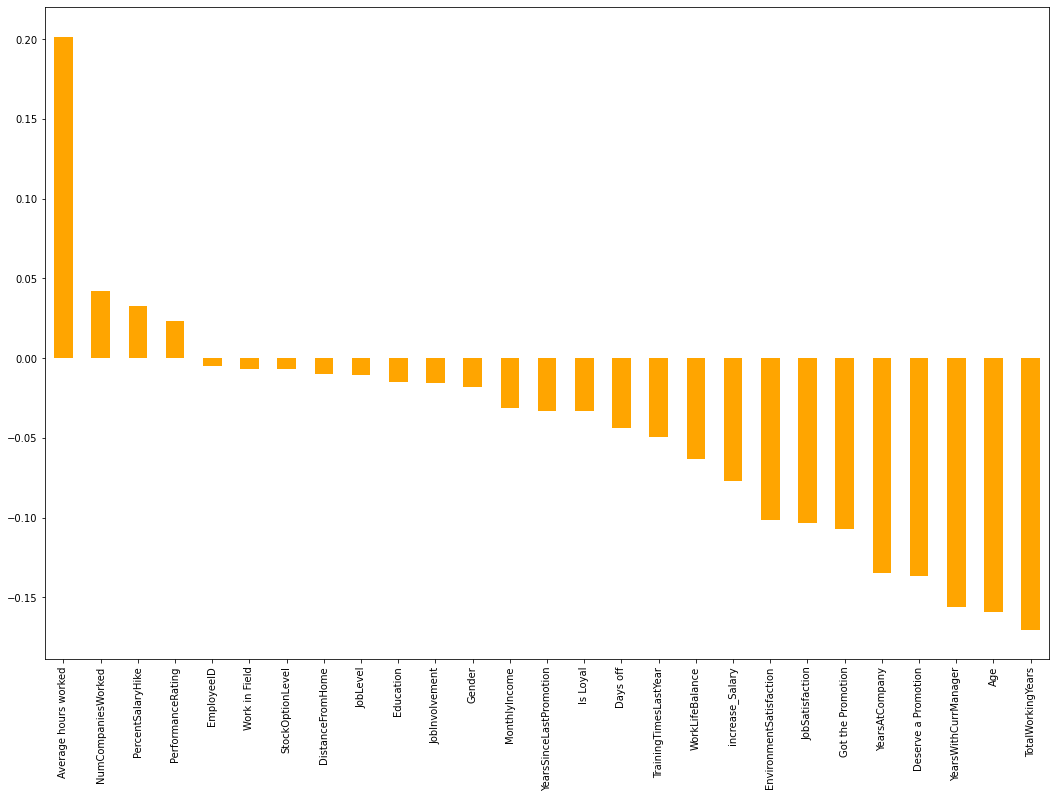

In [ ]:
plt.figure(figsize=(18,12))
Merge_WH_ALLData.corr()['Attrition'].sort_values(ascending=False)[1:].plot.bar(color='orange')

# Feauture Engineering

In [ ]:
#Getting all the column headers printed out
for col in Merge_WH_ALLData.columns:
  print(col)

EmployeeID
EnvironmentSatisfaction
JobSatisfaction
WorkLifeBalance
JobInvolvement
PerformanceRating
Age
Attrition
BusinessTravel
Department
DistanceFromHome
Education
EducationField
EmployeeCount
Gender
JobLevel
JobRole
MaritalStatus
MonthlyIncome
NumCompaniesWorked
Over18
PercentSalaryHike
StandardHours
StockOptionLevel
TotalWorkingYears
TrainingTimesLastYear
YearsAtCompany
YearsSinceLastPromotion
YearsWithCurrManager
Average hours worked
Days off


In [ ]:
#Finding out which columns are type object to encode them
Merge_WH_ALLDataColumns_OBJ = Merge_WH_ALLData.select_dtypes(include = ['object']).columns
Merge_WH_ALLDataColumns_OBJ

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')

In [ ]:
#Making sure that the Over18 column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['Over18']:
  if i=='Y':
    cnt+=1
print(cnt)
#Making sure that the StandardHours column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['StandardHours']:
  if i==8:
    cnt+=1
print(cnt)
#Making sure that the EmployeeCount column only holds 1 value thus removing it
cnt=0
for i in Merge_WH_ALLData['EmployeeCount']:
  if i==1:
    cnt+=1
print(cnt)


# Dropping those three columns as they add no value to the data
Merge_WH_ALLData.drop(['Over18','EmployeeCount','StandardHours'],axis=1,inplace=True)

Merge_WH_ALLData.shape

4410
4410
4410


(4410, 28)

In [ ]:
##Creating a new Feature that assess whether the employee deserves a promotion or not
#Setting a list parameter to append in it 1 for deserving a promotion and 0 for those who do not deserve one
lis=[]
for index, row in Merge_WH_ALLData[['TotalWorkingYears','YearsAtCompany']].iterrows():
#Assessing whether the employee deserves the promotion
  if row['TotalWorkingYears']<=10 and row['YearsAtCompany']>=4:
    lis.append(1)

  elif  row['TotalWorkingYears']>10 and row['TotalWorkingYears']<=20 and row['YearsAtCompany']>=7:
    lis.append(1)

  elif row['TotalWorkingYears']>20 and row['TotalWorkingYears']<=30 and row['YearsAtCompany']>=10:
    lis.append(1)
    
#Everyone one else that did not meet any of the above criteria does not deserve a promotion
  else:
    lis.append(0)
Merge_WH_ALLData['Deserve a Promotion']=lis
Merge_WH_ALLData['Deserve a Promotion'].value_counts()

1    2587
0    1823
Name: Deserve a Promotion, dtype: int64

In [ ]:
##Creating a new Feature that assess whether the employeegot the promotion he derserves or not
#Setting a list parameter to append in it 1 for getting the promotion and 0 for those who do not deserve one or not getting it
lis=[]
for index, row in Merge_WH_ALLData[['YearsSinceLastPromotion','Deserve a Promotion','TotalWorkingYears']].iterrows():
#Leaving out the one who do not deserve the promotion
  if row['Deserve a Promotion']==0:
    lis.append(0)
#Assessing whether he deserves the promotion and got it
  elif row['Deserve a Promotion']==1 and row['TotalWorkingYears']<=10 and row['YearsSinceLastPromotion']<2:
    lis.append(1)

  elif row['Deserve a Promotion']==1 and row['TotalWorkingYears']<=20 and row['YearsSinceLastPromotion']<4:
    lis.append(1)

  elif row['Deserve a Promotion']==1 and row['TotalWorkingYears']<=30 and row['YearsSinceLastPromotion']<5:
    lis.append(1)
    
#If they did not match the above criteria means they do not got the promotion they deserve
  else:
    lis.append(2)
Merge_WH_ALLData['Got the Promotion']=lis
Merge_WH_ALLData['Got the Promotion'].value_counts()

1    1882
0    1823
2     705
Name: Got the Promotion, dtype: int64

In [ ]:
##Creating a new Feature that assess whether the employee is loyal or not
#Setting a list parameter to append in it 1 if they are loyal and 0 for those who are not
lis=[]
#Assessing whether he is loyal or not
for index, row in Merge_WH_ALLData[['TotalWorkingYears','YearsAtCompany','NumCompaniesWorked']].iterrows():
  try:
    a=row['TotalWorkingYears']/row['NumCompaniesWorked']
  except:
    a=row['TotalWorkingYears']

  if row['NumCompaniesWorked']==0 and row['YearsAtCompany']>=5:
    lis.append(1)

  elif a>=10:
    lis.append(1)

  elif row['YearsAtCompany']/row['TotalWorkingYears']>=0.8:
    lis.append(1)

  elif row['YearsAtCompany']-row['TotalWorkingYears']==-1:
    lis.append(1)

#Everyone else is not loyal
  else:
    lis.append(0)
Merge_WH_ALLData['Is Loyal']=lis
Merge_WH_ALLData['Is Loyal'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


1    2492
0    1918
Name: Is Loyal, dtype: int64

In [ ]:
# Create New Feature based on the 'MonthlyIncome','JobSatisfaction','YearsAtCompany' Features to show 
# if the employee deserve increase his salary or not
lis=[]
for index, row in Merge_WH_ALLData[['MonthlyIncome','JobSatisfaction','YearsAtCompany']].iterrows():
  if row['MonthlyIncome']<=200000 and row['YearsAtCompany']<=40 and row['JobSatisfaction']>=3:
    lis.append(1)
  elif row['MonthlyIncome']<=100000 and row['YearsAtCompany']<=30 and row['JobSatisfaction']>=3:
    lis.append(1)
  elif row['MonthlyIncome']>=50000 and row['YearsAtCompany']>30 and row['JobSatisfaction']>=3:
    lis.append(1)
  else:
    lis.append(0)
Merge_WH_ALLData['increase_Salary']=lis
Merge_WH_ALLData['increase_Salary'].value_counts()

1    2710
0    1700
Name: increase_Salary, dtype: int64

In [ ]:
##Assessing whether the employee is working in the same field he study or not
#1 if He is 0 if he is not
LS='Healthcare Representative'
MD=['Research Scientist','Research Director']
Mrk=['Sales Executive','Sales Representative','Manager']
HR=['Human Resources','Manager']
TD=['Laboratory Technician','Manufacturing Director']
lis=[]
for index, row in Merge_WH_ALLData[['EducationField','JobRole']].iterrows():
  if row['EducationField']=='Life Sciences' and row['JobRole']in LS:
    lis.append(1)
  elif row['EducationField']=='Medical' and row['JobRole']in MD:
    lis.append(1)
  elif row['EducationField']=='Marketing' and row['JobRole']in Mrk:
    lis.append(1)
  elif row['EducationField']=='Technical Degree' and row['JobRole']in TD:
    lis.append(1)
  elif row['EducationField']=='Human Resources' and row['JobRole']in HR:
    lis.append(1)
  else:
    lis.append(0)
Merge_WH_ALLData['Work in Field']=lis
Merge_WH_ALLData['Work in Field'].value_counts()

0    3603
1     807
Name: Work in Field, dtype: int64

In [ ]:
# Encode Gender and Attrition with 2 values where i set it with 0 & 1 
Merge_WH_ALLData["Gender"] = np.where(Merge_WH_ALLData["Gender"].str.contains("Female"), 1, 0)
Merge_WH_ALLData["Attrition"] = np.where(Merge_WH_ALLData["Attrition"].str.contains("Yes"), 1, 0)

In [ ]:
#Two methods to encoding the categorical columns into numerical categorical ones


##The first method turns every unique value in the column into a number from 0 to length(column)-1
##and then saves the value with the mathcing number into a dict to be able to find it later on
# need_encode=['BusinessTravel', 'Department', 'EducationField',
#        'JobRole', 'MaritalStatus']
# encoding_dict={}
# for item in need_encode:
#   unique_value=(Merge_WH_ALLData[item].unique())
#   x=0
#   unique_dict={}
#   for i in unique_value:
#     Merge_WH_ALLData[item].replace(i,x,inplace=True)
#     unique_dict[x]=i
#     x+=1
# #Creating a dictionary of dictionaries that helps the user find what each number in each of those 5 columns means
#   encoding_dict[item]=unique_dict


# print(encoding_dict)

#The second method uses a library to hot-enocde the columns
transformer_encod = make_column_transformer(
    (OneHotEncoder(), ['BusinessTravel', 'Department', 'EducationField',
       'JobRole', 'MaritalStatus']),
    remainder='passthrough')

transformed_encod = transformer_encod.fit_transform(Merge_WH_ALLData)
transformed_df = pd.DataFrame(transformed_encod, columns=transformer_encod.get_feature_names())
print(transformed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 52 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   onehotencoder__x0_Non-Travel                 4410 non-null   float64
 1   onehotencoder__x0_Travel_Frequently          4410 non-null   float64
 2   onehotencoder__x0_Travel_Rarely              4410 non-null   float64
 3   onehotencoder__x1_Human Resources            4410 non-null   float64
 4   onehotencoder__x1_Research & Development     4410 non-null   float64
 5   onehotencoder__x1_Sales                      4410 non-null   float64
 6   onehotencoder__x2_Human Resources            4410 non-null   float64
 7   onehotencoder__x2_Life Sciences              4410 non-null   float64
 8   onehotencoder__x2_Marketing                  4410 non-null   float64
 9   onehotencoder__x2_Medical                    4410 non-null   float64
 10  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

A=transformed_df
train_df=transformed_df.sample(frac = 0.8)
train_df.shape
for ind,row in train_df.iterrows():
  A.drop([ind],inplace= True, axis=0)
test_df=A
print(test_df.shape)
print(train_df.shape)

(882, 52)
(3528, 52)


In [ ]:
df_majority = train_df[train_df.Attrition==0]
df_minority = train_df[train_df.Attrition==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results
df_majority_undersampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results                                 
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled,df_majority_undersampled])

In [ ]:
FE=df_upsampled
FE.shape
test_df.shape

(882, 52)

# Logistic Regression

In [ ]:
# Getting the data ready for feauture selection
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
X = Data.loc[:, columnName]
Y = Data.loc[:, ['Attrition']]
print(len(columnName))

50


In [ ]:
#Setting hyperparameters as default for the first iteration
C=1
sol='liblinear'
pen='l2'

In [ ]:
# Repopulating ColumnName as it empties at the end of each loop
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
# Initializing parameters for feauture selection
sco_glob=0
lis_sco=[]
lis_nf=[]
# For number of selected feautures r, evualuating the best f1 score
for r in range(len(columnName),0,-1):
  sco=0
  for s in itertools.combinations(columnName,r):
    x = Data.loc[:, s]
    y = Data.loc[:, ['Attrition']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
    model = LogisticRegression(solver=sol,penalty=pen,C=C)
    model.fit(X_train, y_train)
    a=f1_score(y_test, model.predict(X_test))
    if a>sco:
      lis=s 
      sco=a
# Saving each best score for each number of selected feautures  
  lis_sco.append(sco)
  lis_nf.append(r)
  for i in columnName:
    if i in lis:
      l=1
    else:
      columnName.remove(i)
# Saving the best score with the corresponding selected feautures to be able to use them later on 
  if sco>sco_glob:
    sco_glob=sco
    lis_glob=lis
    

('onehotencoder__x0_Non-Travel', 'onehotencoder__x0_Travel_Frequently', 'onehotencoder__x0_Travel_Rarely', 'onehotencoder__x1_Human Resources', 'onehotencoder__x1_Research & Development', 'onehotencoder__x1_Sales', 'onehotencoder__x2_Human Resources', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x2_Marketing', 'onehotencoder__x2_Medical', 'onehotencoder__x2_Other', 'onehotencoder__x2_Technical Degree', 'onehotencoder__x3_Healthcare Representative', 'onehotencoder__x3_Human Resources', 'onehotencoder__x3_Laboratory Technician', 'onehotencoder__x3_Manager', 'onehotencoder__x3_Manufacturing Director', 'onehotencoder__x3_Research Director', 'onehotencoder__x3_Research Scientist', 'onehotencoder__x3_Sales Executive', 'onehotencoder__x3_Sales Representative', 'onehotencoder__x4_Divorced', 'onehotencoder__x4_Married', 'onehotencoder__x4_Single', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'PerformanceRating', 'Age', 'DistanceFromHome', 'Gender', 'MonthlyIncome', 'StockOptionLevel', 'T

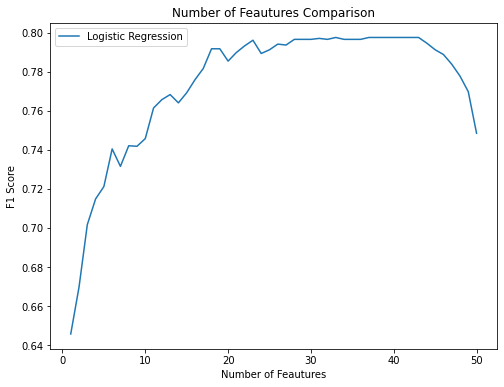

In [ ]:
# Showing the selected feautures and how many
print(lis_glob)
print(len(lis_glob))

# Plotting Number of feautures vs F1 score
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(lis_nf,lis_sco,label='Logistic Regression')
plt.xlabel('Number of Feautures')
plt.ylabel('F1 Score')
plt.title('Number of Feautures Comparison')
plt.legend()
plt.show()

In [ ]:
# Initializing the model
columnName=lis_glob
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
model = LogisticRegression(solver=sol,penalty=pen,C=C)
model.fit(X_train,y_train)
# Getting precision and recall for different Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
# Getting F1 score for each Thresholds
fscore = (2 * precision * recall) / (precision + recall)
# Locating the index of the highest F! score
ix = argmax(fscore)
print('Best Threshold=%f, F1-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],precision[ix],recall[ix]))
# Calculating 0 and 1 manually with best F1 score Threshold
Threshold = thresholds[ix]
pred_proba=model.predict_proba(X_test)
preds=[]
for i in pred_proba:
  if i[1]>=Threshold:
    preds.append(1)
  else:
    preds.append(0)
# Showing Best F1 Score location
plt.scatter(recall[ix], precision[ix], marker='x', color='black', label='Best',s=100)
# Plotting Precision-Recall Curve
plt.plot(recall, precision, marker='.', label='Categorical Naive Bayes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# Comparing scores for model.predict and manually predited values
print('Scores for best threshold Scores for model.predict')
print('Recall:',recall_score(y_test, preds),recall_score(y_test,  model.predict(X_test)))
print('Precision:',precision_score(y_test,preds),precision_score(y_test, model.predict(X_test)))
print('F1 score:',f1_score(y_test, preds),f1_score(y_test,  model.predict(X_test)))

0.8354621102712706 0.7923051434501817


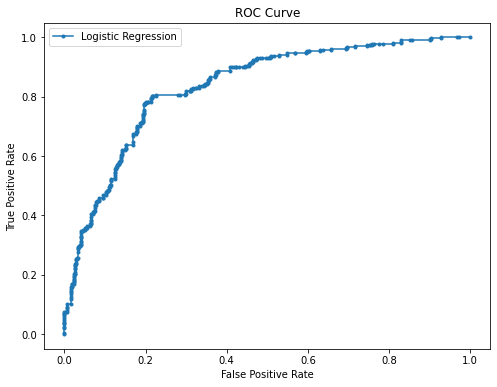

In [ ]:
# Plotting the ROC curve 
lr_fpr, lr_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
lr_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(lr_auc,roc_auc_score(y_test, preds))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
#Getting confusion matrix for default threshold
cm = confusion_matrix(y_test,model.predict(X_test))
cm

array([[307,  86],
       [ 80, 327]])

In [ ]:
#Getting confusion matrix for best F1 score threshold
cm = confusion_matrix(y_test,preds)
cm

array([[307,  86],
       [ 80, 327]])

In [ ]:
#Doing a cross validation to asses whether the model will perform well in real world or no
columnName=lis_glob
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
model = LogisticRegression(solver=sol,penalty=pen,C=C)
cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, x, y, scoring='f1', cv=cv, n_jobs=-1)
model.fit(X_train, y_train)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm 

Accuracy: 0.765 (0.021)


In [ ]:
# Setting the hyperparamter that the grid search will look into
solvers=['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
penalty=['l1', 'l2', 'elasticnet', 'none']
C_val=[1000,100,10,1,0.1,0.01,0.001]
#Doing a grid search for best alpha with cross validation
columnName=lis_glob
model = LogisticRegression()
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
grid = dict(solver=solvers,penalty=penalty,C=C_val)
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=444)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(x, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))




In [ ]:
 # Getting best parameter alpha and setting it for the next iteration
 a=grid_result.best_params_
 C=a['C']
 pen=a['penalty']
 sol=a['solver']


# Naive Bayes

In [ ]:
# Imprting the different Naive Bayes algorithms
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Getting the data ready for algorithms and feauture selection
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
X = Data.loc[:, columnName]
Y = Data.loc[:, ['Attrition']]
print(len(columnName))

50


In [ ]:
# Initializing parameters for algorithms and feauture selection
lis_sco_mo=[]
lis_nf_mo=[]
models=[BernoulliNB(),CategoricalNB(),ComplementNB(),GaussianNB(),MultinomialNB()]
# Iterating through each model
for m in models:
  sco_glob=0
  lis_sco=[]
  lis_nf=[]
# Repopulating ColumnName as it empties at the end of each loop
  Data=FE.drop(['EmployeeID'],axis=1)
  columnName=[]
  for col,v in Data.iteritems():
    columnName.append(col)
  columnName.remove('Attrition')
# For each model, evualuating the best f1 score for best r selected feautures between all columns and 1 column only
  for r in range(len(columnName),0,-1):
    sco=0
    for s in itertools.combinations(columnName,r):
      x = Data.loc[:, s]
      y = Data.loc[:, ['Attrition']]
      X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
      model = m
      model.fit(X_train, y_train)
      a=f1_score(y_test, model.predict(X_test))
      if a>sco:
        lis=s 
        sco=a
# Saving each best score for each number of selected feautures
    lis_sco.append(sco)
    lis_nf.append(r)
    for i in columnName:
      if i in lis:
        l=1
      else:
        columnName.remove(i)
# Saving the number of feautures selected and its corresponding score into a global list to compare algorithms
  lis_sco_mo.append(lis_sco)
  lis_nf_mo.append(lis_nf)

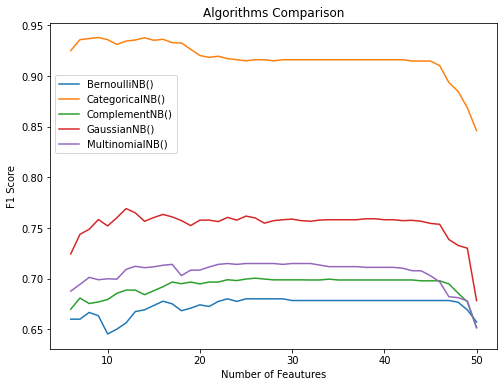

In [ ]:
# Plotting Number of feautures vs F1 score for each model
for i in range(0,len(lis_sco_mo)):
  plt.plot(lis_nf_mo[i][:-5],lis_sco_mo[i][:-5],label=models[i])
plt.rcParams["figure.figsize"] = (8,6)
plt.legend(loc=(0.01, 0.6))
plt.xlabel('Number of Feautures')
plt.ylabel('F1 Score')
plt.title('Algorithms Comparison')
plt.show()

In [ ]:
#Setting alpha as default for the first iteration
alpha=1

50


In [ ]:
# Repopulating ColumnName as it empties at the end of each loop
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
# Initializing parameters for feauture selection
sco_glob=0
lis_sco=[]
lis_nf=[]
# For number of selected feautures r, evualuating the best f1 score
for r in range(len(columnName),5,-1):
  sco=0
  for s in itertools.combinations(columnName,r):
    x = Data.loc[:, s]
    y = Data.loc[:, ['Attrition']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
    model = CategoricalNB(alpha=alpha)
    model.fit(X_train, y_train)
    a=f1_score(y_test, model.predict(X_test))
    if a>sco:
      lis=s 
      sco=a
# Saving each best score for each number of selected feautures    
  lis_sco.append(sco)
  lis_nf.append(r)
  for i in columnName:
    if i in lis:
      l=1
    else:
      columnName.remove(i)
# Saving the best score with the corresponding selected feautures to be able to use them later on 
  if sco>sco_glob:
    sco_glob=sco
    lis_glob=lis

('onehotencoder__x0_Non-Travel', 'onehotencoder__x0_Travel_Frequently', 'onehotencoder__x0_Travel_Rarely', 'onehotencoder__x1_Human Resources', 'onehotencoder__x1_Research & Development', 'onehotencoder__x1_Sales', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x2_Marketing', 'onehotencoder__x2_Medical', 'onehotencoder__x2_Other', 'onehotencoder__x2_Technical Degree', 'onehotencoder__x3_Healthcare Representative', 'onehotencoder__x3_Human Resources', 'onehotencoder__x3_Laboratory Technician', 'onehotencoder__x3_Manager', 'onehotencoder__x3_Manufacturing Director', 'onehotencoder__x3_Research Director', 'onehotencoder__x3_Research Scientist', 'onehotencoder__x3_Sales Executive', 'onehotencoder__x3_Sales Representative', 'onehotencoder__x4_Divorced', 'onehotencoder__x4_Married', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',

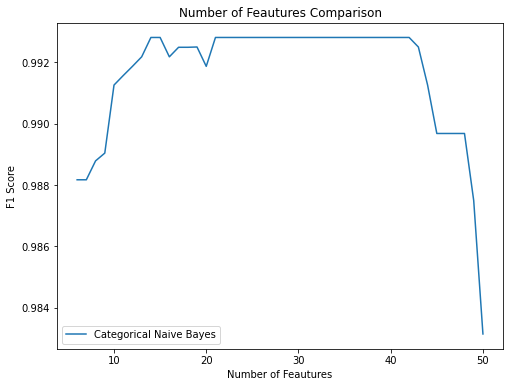

In [ ]:
# Showing the selected feautures and how many
print(lis_glob)
print(len(lis_glob))

# Plotting Number of feautures vs F1 score
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(lis_nf,lis_sco,label='Categorical Naive Bayes')
plt.xlabel('Number of Feautures')
plt.ylabel('F1 Score')
plt.title('Number of Feautures Comparison')
plt.legend()
plt.show()

31
Best Threshold=0.516488, F1-Score=0.971, Precision=0.957, Recall=0.985


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


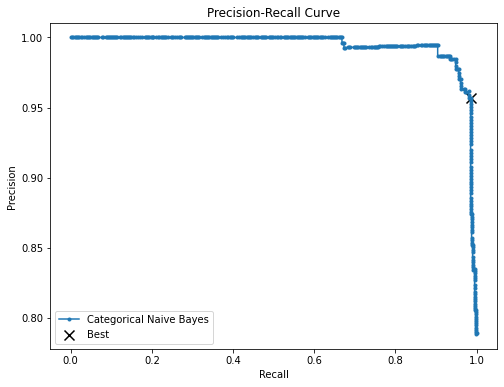

Scores for best threshold Scores for model.predict
Recall: 0.9852579852579852 0.9852579852579852
Precision: 0.9570405727923628 0.9570405727923628
F1 score: 0.9709443099273608 0.9709443099273608


In [ ]:
# Initializing the model
columnName=lis_glob
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = .8)
model = CategoricalNB(alpha=alpha)
model.fit(X_train,y_train)
# Getting precision and recall for different Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
# Getting F1 score for each Thresholds
fscore = (2 * precision * recall) / (precision + recall)
# Locating the index of the highest F! score
ix = argmax(fscore)
print('Best Threshold=%f, F1-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],precision[ix],recall[ix]))
# Calculating 0 and 1 manually with best F1 score Threshold
Threshold = thresholds[ix]
pred_proba=model.predict_proba(X_test)
preds=[]
for i in pred_proba:
  if i[1]>=Threshold:
    preds.append(1)
  else:
    preds.append(0)
# Showing Best F1 Score location
plt.scatter(recall[ix], precision[ix], marker='x', color='black', label='Best',s=100)
# Plotting Precision-Recall Curve
plt.plot(recall, precision, marker='.', label='Categorical Naive Bayes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# Comparing scores for model.predict and manually predited values
print('Scores for best threshold Scores for model.predict')
print('Recall:',recall_score(y_test, preds),recall_score(y_test,  model.predict(X_test)))
print('Precision:',precision_score(y_test,preds),precision_score(y_test, model.predict(X_test)))
print('F1 score:',f1_score(y_test, preds),f1_score(y_test,  model.predict(X_test)))

0.9937981006683296 0.9697282292702141


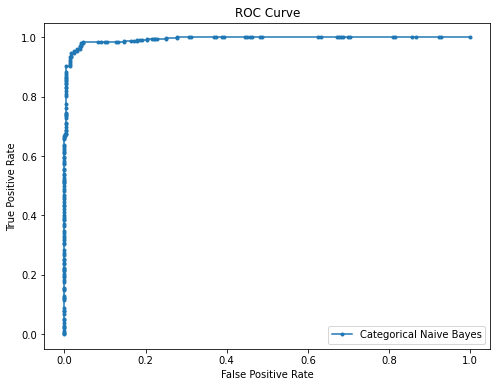

In [ ]:
# Plotting the ROC curve 
lr_fpr, lr_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(lr_fpr, lr_tpr, marker='.', label='Categorical Naive Bayes')
lr_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(lr_auc,roc_auc_score(y_test, preds))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
#Getting confusion matrix for default threshold
cm = confusion_matrix(y_test,model.predict(X_test))
cm

array([[375,  18],
       [  6, 401]])

In [ ]:
#Getting confusion matrix for best F1 score threshold
cm = confusion_matrix(y_test,preds)
cm

array([[375,  18],
       [  6, 401]])

In [ ]:
#Doing a cross validation to asses whether the model will perform well in real world or no
columnName=lis_glob
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
model = CategoricalNB(alpha=alpha)
cv=StratifiedKFold(n_splits=10, shuffle=False)
scores = cross_val_score(model, x, y, scoring='f1', cv=cv, n_jobs=-1)
scores=scores[~np.isnan(scores)]
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.960 (0.011)


In [ ]:
# Setting the hyperparamter that the grid search will look into
param={'alpha': list(np.logspace(0,-9,200))}

#Doing a grid search for best alpha with cross validation
columnName=lis_glob
model = CategoricalNB()
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=444)
grid_search = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(x, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.865074 using {'alpha': 0.009221978823334321}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Getting best parameter alpha and setting it for the next iteration
a=grid_result.best_params_
alpha=a['alpha']

# Random Forest

In [ ]:
 from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Getting the data ready for algorithms and feauture selection
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
X_train = Data.loc[:, columnName]
y_train = Data.loc[:, ['Attrition']]
X_test=test_df.loc[:, columnName]
y_test=test_df.loc[:, ['Attrition']]
print(len(columnName))

50


In [ ]:
#Default Values
num_of_fea=100
max_features='auto'
max_depth=5
min_samples_split=2
min_samples_leaf=1
bootstrap=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was pas

Text(0.5, 0, 'N of Estimators')

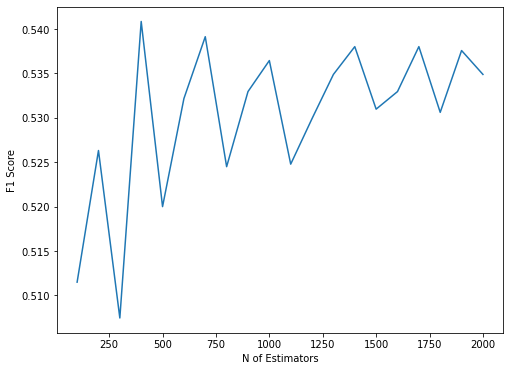

In [ ]:
#Assessing the hyperparameter n_estimators
lis_num=list(range(100,2100,100))
lis=[]
for i in lis_num:
  model=RandomForestClassifier(max_depth=max_depth, n_estimators=i, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
  model.fit(X_train,y_train)
  a=f1_score(y_test, model.predict(X_test))
  lis.append(a)
plt.plot(lis_num,lis)
plt.ylabel('F1 Score')
plt.xlabel('N of Estimators')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Text(0.5, 0, 'Max Features')

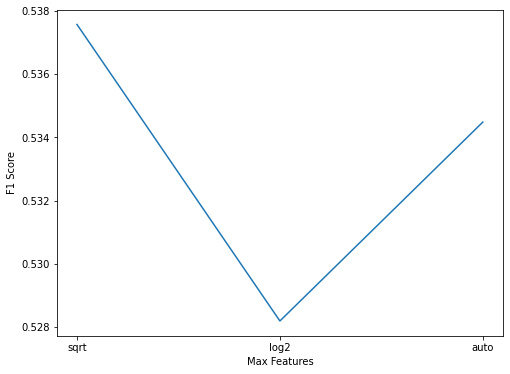

In [ ]:
#Assessing the hyperparameter max_features
lis_num=['sqrt', 'log2','auto']
num_of_fea=400
lis=[]
for i in lis_num:
  model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=i, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
  model.fit(X_train,y_train)
  a=f1_score(y_test, model.predict(X_test))
  lis.append(a)
plt.plot(lis_num,lis)
plt.ylabel('F1 Score')
plt.xlabel('Max Features')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConv

Text(0.5, 0, 'Min Sample Split')

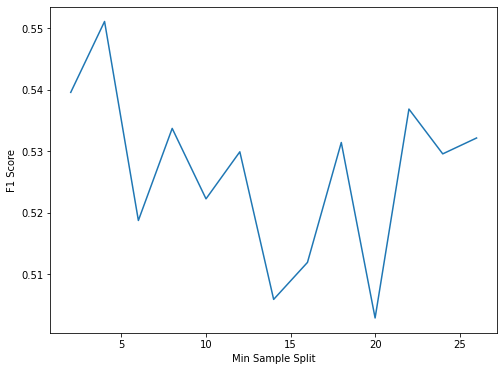

In [ ]:
#Assessing the hyperparameter min_samples_split
lis_num=list(range(2,27,2))
max_features='sqrt'
lis=[]
for i in lis_num:
  model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=i, bootstrap=bootstrap)
  model.fit(X_train,y_train)
  a=f1_score(y_test, model.predict(X_test))
  lis.append(a)
plt.plot(lis_num,lis)
plt.ylabel('F1 Score')
plt.xlabel('Min Sample Split')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConv

Text(0.5, 0, 'Min Sample Leaf')

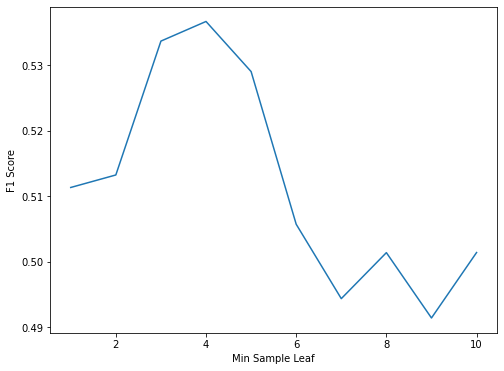

In [ ]:
#Assessing the hyperparameter max_features
lis_num=list(range(1,11,1))
min_samples_split=6
lis=[]
for i in lis_num:
  model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=i, min_samples_split=min_samples_split, bootstrap=bootstrap)
  model.fit(X_train,y_train)
  a=f1_score(y_test, model.predict(X_test))
  lis.append(a)
plt.plot(lis_num,lis)
plt.ylabel('F1 Score')
plt.xlabel('Min Sample Leaf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Text(0.5, 0, 'BootStrap')

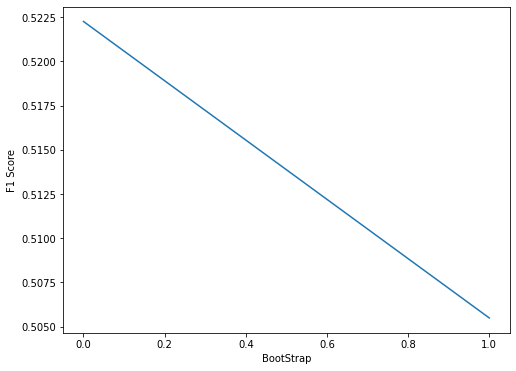

In [ ]:
#Assessing the hyperparameter bootstrap
lis_num=[True,False]
min_samples_leaf=4
lis=[]
for i in lis_num:
  model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=i)
  model.fit(X_train,y_train)
  a=f1_score(y_test, model.predict(X_test))
  lis.append(a)
plt.plot(lis_num,lis)
plt.ylabel('F1 Score')
plt.xlabel('BootStrap')

In [ ]:
#Recap Values
num_of_fea=200
max_features='sqrt'
max_depth=100
min_samples_split=6
min_samples_leaf=2
bootstrap=True

In [ ]:
# Repopulating ColumnName as it empties at the end of each loop
Data=FE.drop(['EmployeeID'],axis=1)
columnName=[]
for col,v in Data.iteritems():
  columnName.append(col)
columnName.remove('Attrition')
# Initializing parameters for feauture selection
sco_glob=0
lis_sco=[]
lis_nf=[]
# For number of selected feautures r, evualuating the best f1 score
for r in range(len(columnName),5,-1):
  sco=0
  for s in itertools.combinations(columnName,r):
    X_train = Data.loc[:, s]
    y_train = Data.loc[:, ['Attrition']]
    model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
    model.fit(X_train, y_train)
    X_test=test_df.loc[:, s]
    y_test=test_df.loc[:, ['Attrition']]
    a=f1_score(y_test, model.predict(X_test))
    if a>sco:
      lis=s 
      sco=a
# Saving each best score for each number of selected feautures    
  lis_sco.append(sco)
  lis_nf.append(r)
  for i in columnName:
    if i in lis:
      l=1
    else:
      columnName.remove(i)
# Saving the best score with the corresponding selected feautures to be able to use them later on 
  if sco>sco_glob:
    sco_glob=sco
    lis_glob=lis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed whe

('onehotencoder__x0_Non-Travel', 'onehotencoder__x0_Travel_Rarely', 'onehotencoder__x1_Human Resources', 'onehotencoder__x1_Sales', 'onehotencoder__x2_Human Resources', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x2_Marketing', 'onehotencoder__x2_Medical', 'onehotencoder__x3_Healthcare Representative', 'onehotencoder__x3_Human Resources', 'onehotencoder__x3_Laboratory Technician', 'onehotencoder__x3_Manufacturing Director', 'onehotencoder__x3_Research Director', 'onehotencoder__x3_Research Scientist', 'onehotencoder__x3_Sales Executive', 'onehotencoder__x4_Divorced', 'onehotencoder__x4_Single', 'EnvironmentSatisfaction', 'JobInvolvement', 'Age', 'DistanceFromHome', 'Education', 'NumCompaniesWorked', 'TotalWorkingYears', 'TrainingTimesLastYear', 'Got the Promotion', 'Work in Field')
27


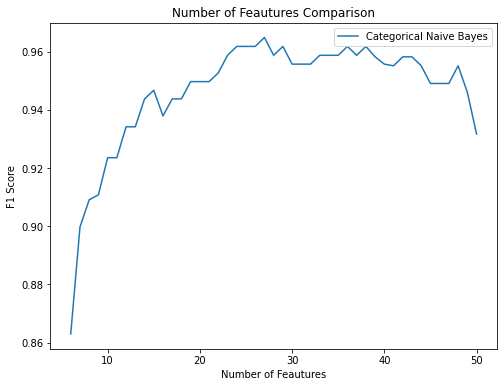

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
[0.9316770186335404, 0.9460317460317461, 0.9551282051282051, 0.9490445859872612, 0.9490445859872612, 0.9490445859872612, 0.9551282051282051, 0.9581993569131833, 0.9581993569131833, 0.9551282051282051, 0.9556962025316457, 0.9581993569131833, 0.961783439490446, 0.9587301587301588, 0.961783439490446, 0.9587301587301588, 0.9587301587301588, 0.9587301587301588, 0.9556962025316457, 0.9556962025316457, 0.9556962025316457, 0.961783439490446, 0.9587301587301588, 0.9648562300319489, 0.961783439490446, 0.961783439490446, 0.961783439490446, 0.9587301587301588, 0.9526813880126184, 0.949685534591195, 0.949685534591195, 0.949685534591195, 0.9437500000000001, 0.9437500000000001, 0.937888198757764, 0.9467084639498433, 0.9437500000000001, 0.9341692789968652, 0.9341692789968652, 0.9235474006116208, 0.9235474006116208, 0.9107692307

In [ ]:
# Showing the selected feautures and how many
print(lis_glob)
print(len(lis_glob))

# Plotting Number of feautures vs F1 score
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(lis_nf,lis_sco,label='Categorical Naive Bayes')
plt.xlabel('Number of Feautures')
plt.ylabel('F1 Score')
plt.title('Number of Feautures Comparison')
plt.legend()
plt.show()
print(lis_nf)
print(lis_sco)

In [ ]:
lis_glob=['onehotencoder__x0_Non-Travel', 'onehotencoder__x0_Travel_Frequently', 'onehotencoder__x0_Travel_Rarely', 'onehotencoder__x1_Research & Development', 'onehotencoder__x1_Sales', 'onehotencoder__x2_Human Resources', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x2_Medical', 'onehotencoder__x2_Other', 'onehotencoder__x2_Technical Degree', 'onehotencoder__x3_Healthcare Representative', 'onehotencoder__x3_Human Resources', 'onehotencoder__x3_Manager', 'onehotencoder__x3_Manufacturing Director', 'onehotencoder__x3_Research Director', 'onehotencoder__x3_Research Scientist', 'onehotencoder__x3_Sales Executive', 'onehotencoder__x3_Sales Representative', 'onehotencoder__x4_Divorced', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'Age', 'DistanceFromHome', 'Education', 'Gender', 'MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Average hours worked', 'Days off', 'Is Loyal', 'increase_Salary']
len(lis_glob)

37

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Best Threshold=0.569295, F1-Score=0.955, Precision=0.949, Recall=0.961


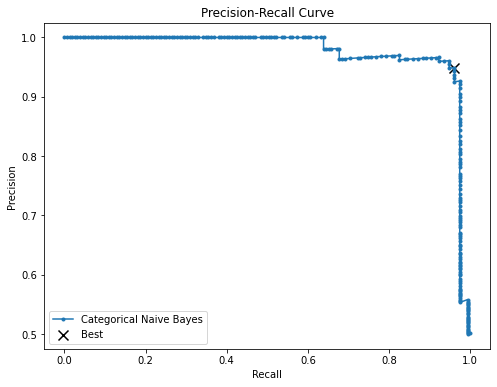

Scores for best threshold Scores for model.predict
Recall: 0.9612903225806452 0.9612903225806452
Precision: 0.9490445859872612 0.9430379746835443
F1 score: 0.9551282051282051 0.952076677316294
Accuracy 0.9829931972789115
Scores for train
Accuracy 0.9995
Recall: 1.0
Precision: 0.999000999000999
F1 score: 0.9995002498750626


In [ ]:
# Initializing the model
columnName=lis_glob
X_train = Data.loc[:, columnName]
y_train = Data.loc[:, ['Attrition']]
X_test=test_df.loc[:, columnName]
y_test=test_df.loc[:, ['Attrition']]
model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
model.fit(X_train,y_train)
# Getting precision and recall for different Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
# Getting F1 score for each Thresholds
fscore = (2 * precision * recall) / (precision + recall)
# Locating the index of the highest F! score
ix = argmax(fscore)
print('Best Threshold=%f, F1-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],precision[ix],recall[ix]))
# Calculating 0 and 1 manually with best F1 score Threshold
Threshold = thresholds[ix]
pred_proba=model.predict_proba(X_test)
preds=[]
for i in pred_proba:
  if i[1]>=Threshold:
    preds.append(1)
  else:
    preds.append(0)
# Showing Best F1 Score location
plt.scatter(recall[ix], precision[ix], marker='x', color='black', label='Best',s=100)
# Plotting Precision-Recall Curve
plt.plot(recall, precision, marker='.', label='Categorical Naive Bayes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# Comparing scores for model.predict and manually predited values
print('Scores for best threshold Scores for model.predict')
print('Recall:',recall_score(y_test, preds),recall_score(y_test,  model.predict(X_test)))
print('Precision:',precision_score(y_test,preds),precision_score(y_test, model.predict(X_test)))
print('F1 score:',f1_score(y_test, preds),f1_score(y_test,  model.predict(X_test)))
print('Accuracy', model.score(X_test,y_test))
print('Scores for train')
print('Accuracy', model.score(X_train,y_train))
print('Recall:',recall_score(y_train,  model.predict(X_train)))
print('Precision:',precision_score(y_train, model.predict(X_train)))
print('F1 score:',f1_score(y_train,  model.predict(X_train)))

0.9965409679113006 0.9747521541740016


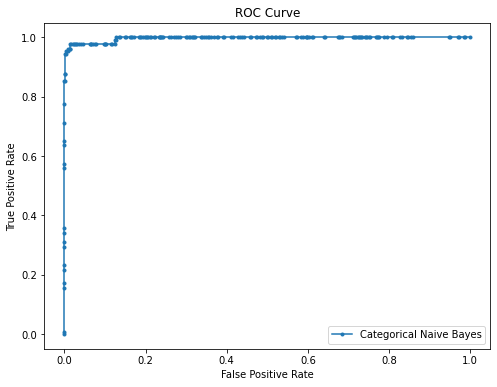

In [ ]:
# Plotting the ROC curve 
lr_fpr, lr_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(lr_fpr, lr_tpr, marker='', label='Categorical Naive Bayes')
lr_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(lr_auc,roc_auc_score(y_test, preds))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
#Getting confusion matrix for default threshold
cm = confusion_matrix(y_test,model.predict(X_test))
cm

array([[746,   7],
       [  6, 123]])

In [ ]:
#Getting confusion matrix for best F1 score threshold
cm = confusion_matrix(y_test,preds)
cm

array([[750,   3],
       [  6, 123]])

In [ ]:
#Doing a cross validation to asses whether the model will perform well in real world or no
columnName=lis_glob
cross_val=pd.concat([Data,test_df])
x = cross_val.loc[:, columnName]
y = cross_val.loc[:, ['Attrition']] 
model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
cv=StratifiedKFold(n_splits=10, shuffle=False)
scores = cross_val_score(model, x, y, scoring='f1', cv=cv, n_jobs=-1)
scores=scores[~np.isnan(scores)]
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.997 (0.006)


In [ ]:
# Setting the hyperparamter that the grid search will look into
max_depth=[2,5,10,25,50,100,200,400,500,None]
min_samples_split=list(range(2,21,2))
min_samples_leaf=list(range(2,11,2))
#Doing a grid search for best alpha with cross validation
columnName=lis_glob
model=RandomForestClassifier()
x = Data.loc[:, columnName]
y = Data.loc[:, ['Attrition']]
grid = dict(max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=444)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(x, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best: 0.991031 using {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [ ]:
 # Getting best parameter alpha and setting it for the next iteration
 a=grid_result.best_params_
 max_depth=a['max_depth']
 min_samples_split=a['min_samples_split']
 min_samples_leaf=a['min_samples_leaf']

In [ ]:
pip install treeinterpreter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserW

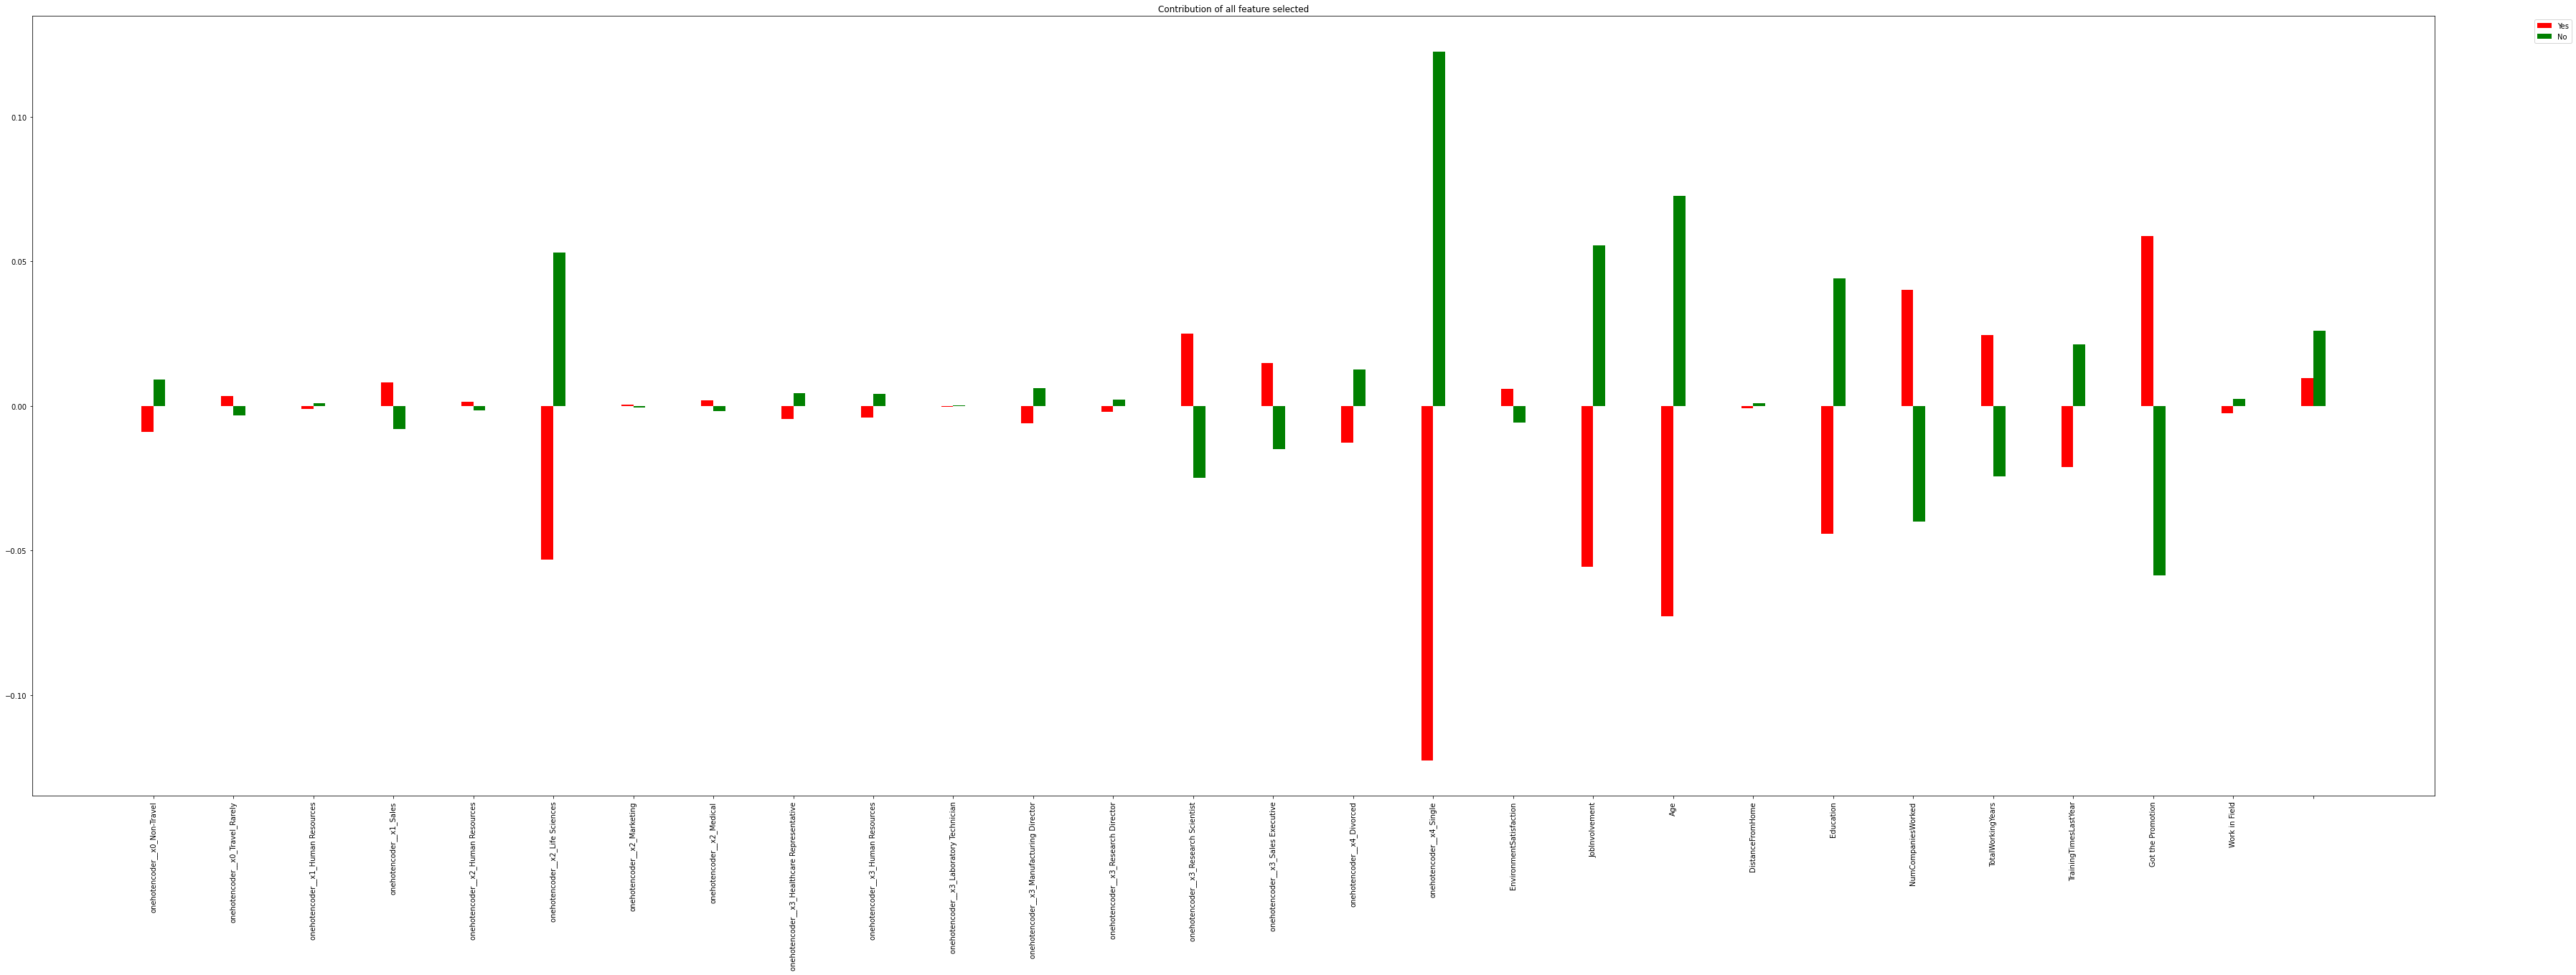

In [ ]:
from treeinterpreter import treeinterpreter as ti
# Initializing the model
columnName=lis_glob
X_train = Data.loc[:, columnName]
y_train = Data.loc[:, ['Attrition']]
X_test=test_df.loc[:, columnName]
y_test=test_df.loc[:, ['Attrition']]
model=RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_fea, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
model.fit(X_train,y_train)
prediction, bias, contributions = ti.predict(model, X_test)
N=len(columnName)+1
yes=[]
no=[]
for j in range(2):
  list_ =  [yes,no]
  for i in range(27):
    val = contributions[0,i,j]
    list_[j].append(val)
yes.append(prediction[0,0]/N)
no.append(prediction[0,1]/N)

plt.rcParams["figure.figsize"] = (60,20)
fig, ax = plt.subplots()
ind = np.arange(N)   
width = 0.15        
p1 = ax.bar(ind, yes, width, color='red', bottom=0)
p2 = ax.bar(ind+width, no, width, color='green', bottom=0)
ax.set_title('Contribution of all feature selected')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(columnName, rotation = 90)
ax.legend((p1[0], p2[0]), ('Yes', 'No') , bbox_to_anchor=(1.04,1), loc="upper left")
ax.autoscale_view()
plt.show()


In [ ]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=columnName,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

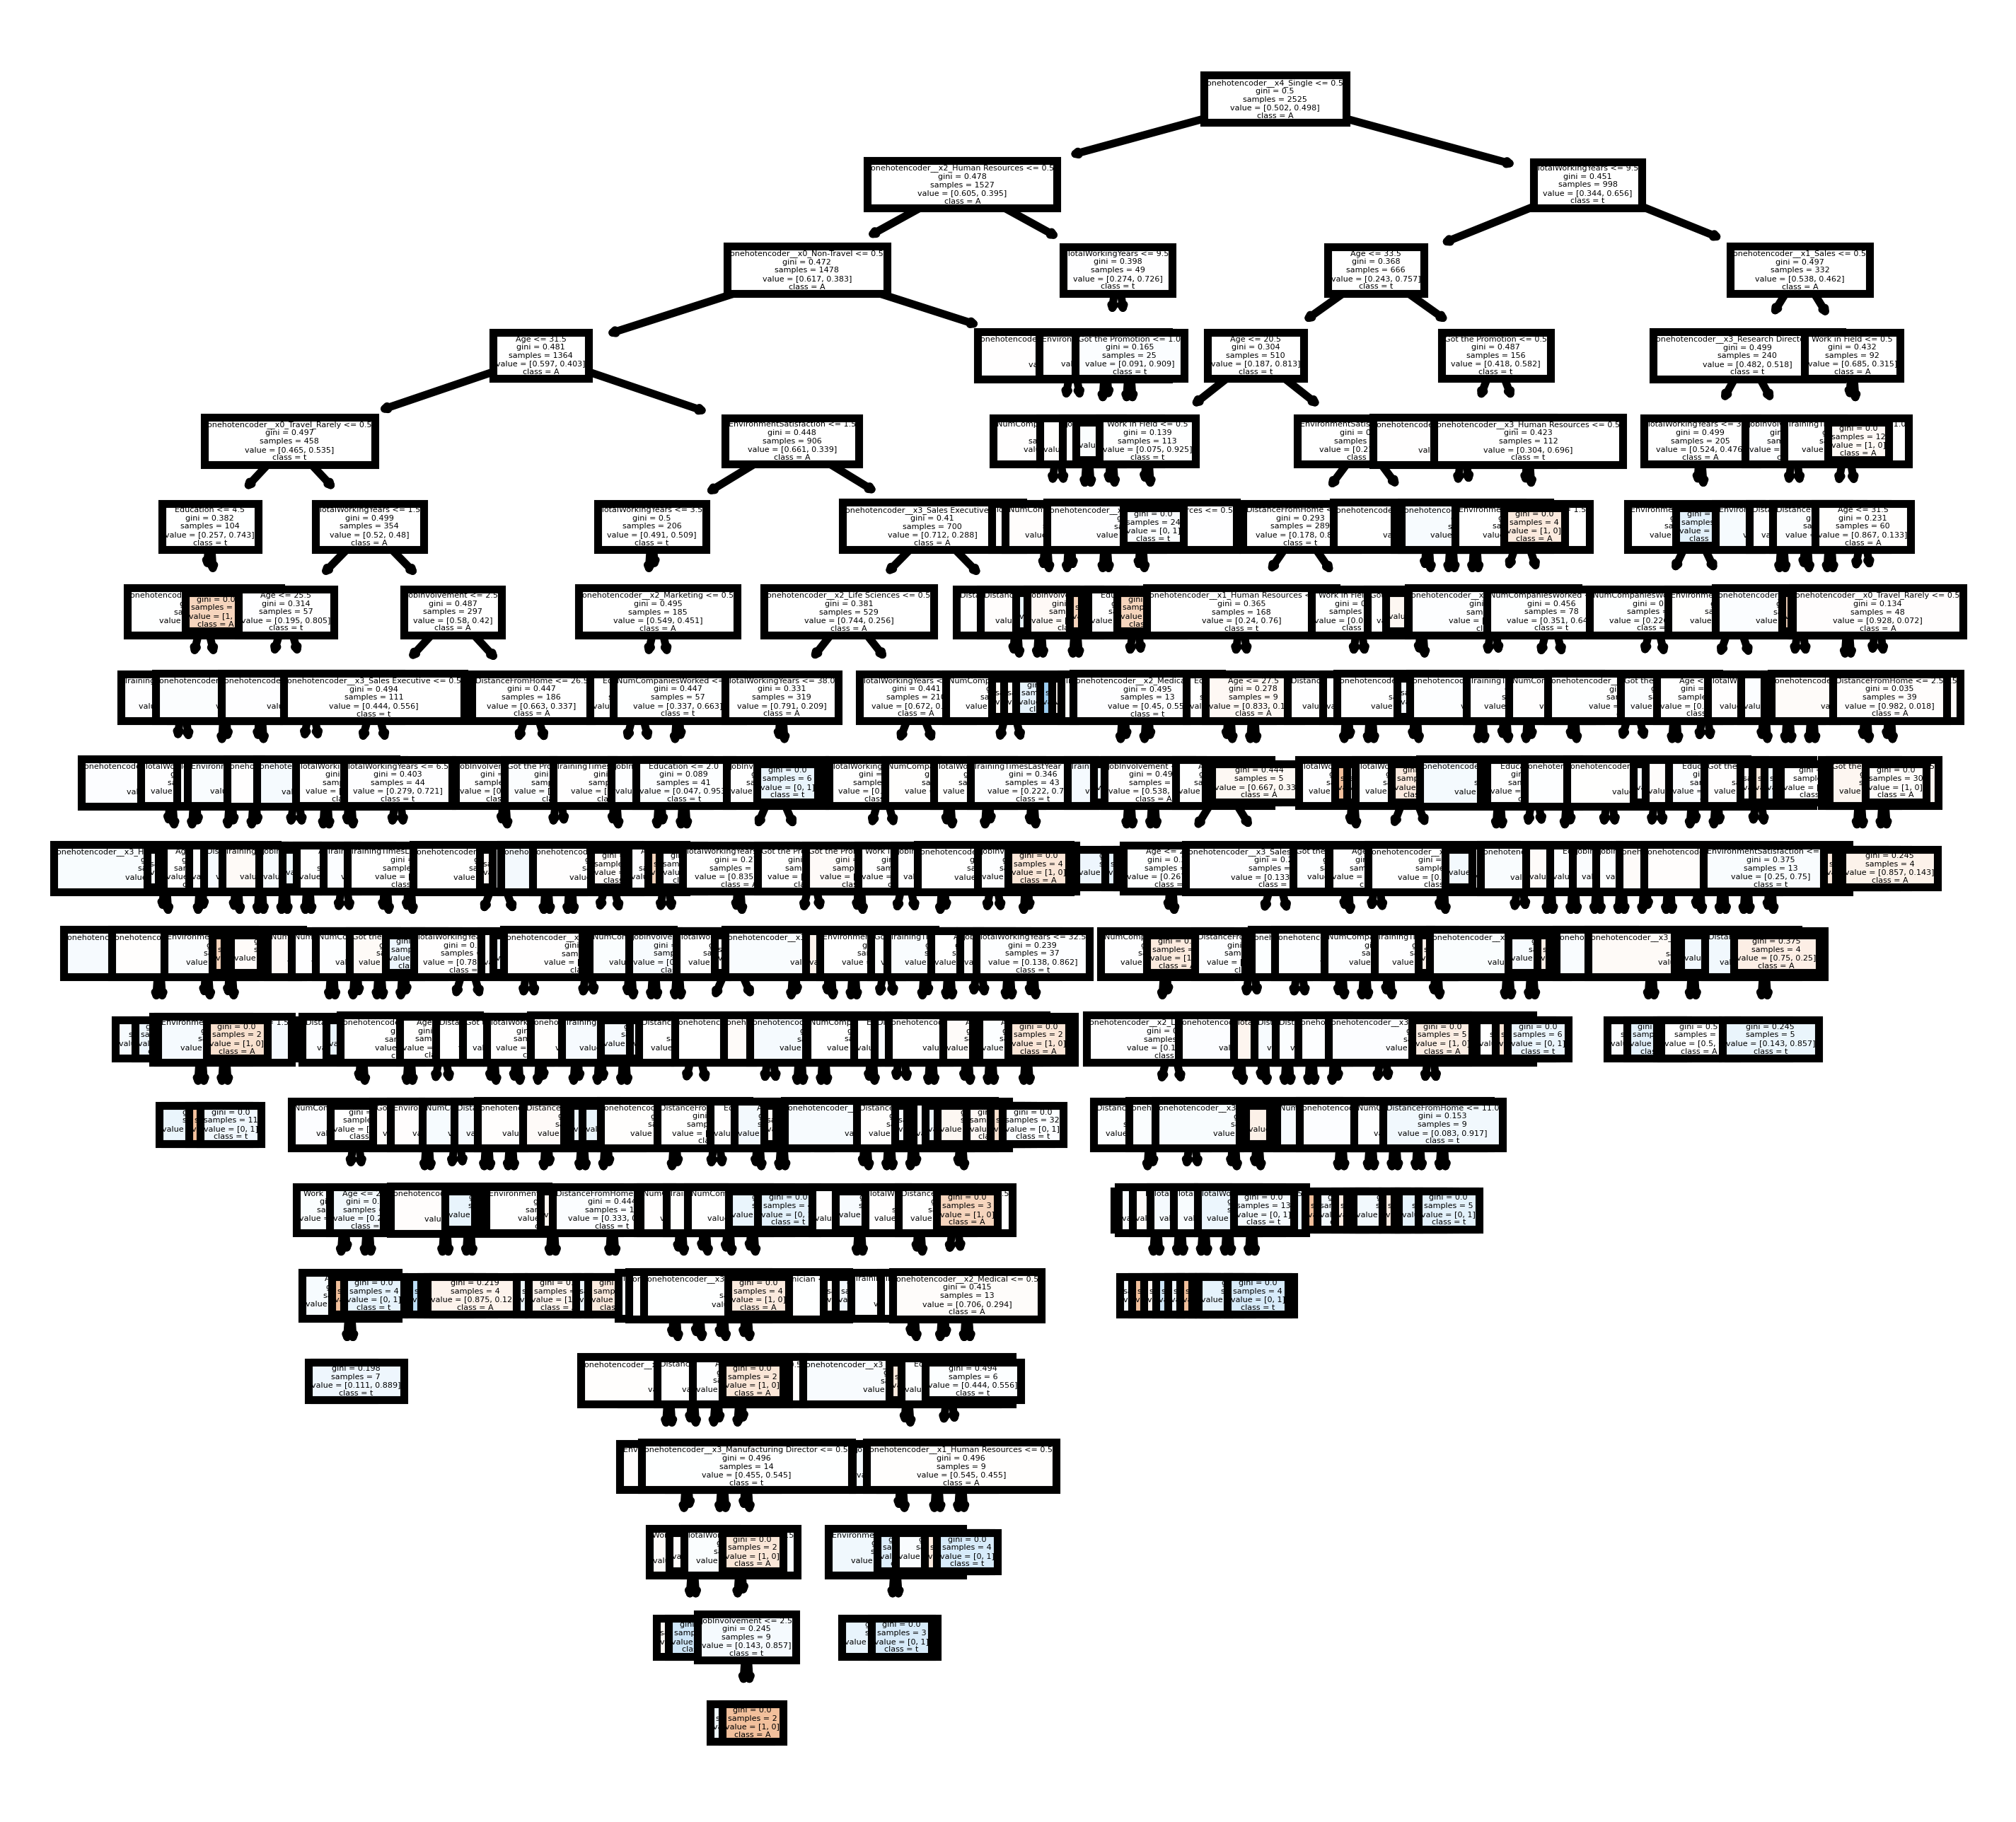

In [ ]:
columnName=lis_glob
fn=columnName
cn='Attrition'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);


# Data Set And UnderSample

In [ ]:
# transformed_df.drop(['Work in Field','increase_Salary',],axis=1,inplace=True)
# transformed_df.drop(['WorkLifeBalance','DistanceFromHome','StockOptionLevel'],axis=1,inplace=True) # because have weak correlation
transformed_df.drop(['EmployeeID'],axis=1,inplace=True) 

In [ ]:
Train_df=transformed_df.sample(frac = 0.8)
print(Train_df.shape)
for ind,row in Train_df.iterrows():
  transformed_df.drop([ind],inplace= True, axis=0)
test_df=transformed_df



print(test_df.shape)
# Getting the data ready for feauture selection
# to check Number of Zeroes at  Attrition feature then check balance or not
# c=0
# for i in transformed_df['Attrition']:
#   if i==1:
#     c+=1
# print(c)

# Data=transformed_df
# X=Data.drop(['Attrition'],axis=1)
# Y=Data['Attrition']
# # to check if the data balance or Not

# #split the data to Training Data and Testing Data to fit our Model
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state = 0,shuffle=True)
# #show the shape of the XTrain
# print("Train Shape",Xtrain.shape)
# #show the shape of the XTest
# print("Test Shape",Xtest.shape)

(3528, 51)
(882, 51)


In [ ]:
# # Second Method to make Resample
# #UnderSample
# from imblearn import under_sampling ,over_sampling
# from imblearn.under_sampling import RandomUnderSampler
# RUs=RandomUnderSampler(random_state=0)
# X_train ,Y_train = RUs.fit_resample(X_train,Y_train)
# print(X.value_counts())
# # print(Y.shape)

In [ ]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import ClusterCentroids 
# X, Y = make_classification(n_classes=2, class_sep=2,
#  weights=[0.161, 0.839], n_informative=3, n_redundant=1, flip_y=0,
#  n_features=45, n_clusters_per_class=1, n_samples=4410, random_state=10)
# print('Original dataset shape {}'.format(Counter(Y)))
# #Original dataset shape Counter({1: 711, 0: 3699})
# cc = ClusterCentroids(random_state=42)
# X, Y = cc.fit_resample(X,Y)
# print('Resampled dataset shape {}'.format(Counter(Y)))
# Original dataset shape Counter({1: 3699, 0: 711})
# Resampled dataset shape Counter({0: 711, 1: 711})

In [ ]:
# # One Mehtod to make ReSample
# df_majority = transformed_df[transformed_df.Attrition==0]
# df_minority = transformed_df[transformed_df.Attrition==1]



#for only Train data

df_majority = Train_df[Train_df.Attrition==0]
df_minority = Train_df[Train_df.Attrition==1]

# underample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results
                                
df_majority_undersampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results                                 
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled,df_majority_undersampled])


In [ ]:

Data=df_upsampled
print(Data.shape)

print(test_df.shape)

# trans = RobustScaler()
# Data = trans.fit_transform(Data)
# dataset = DataFrame(Data)


(4000, 51)
(882, 51)


In [ ]:
# Getting the data ready for feauture selection
# to check Number of Zeroes at  Attrition feature then check balance or not
c=0
for i in Data['Attrition']:
  if i==1:
    c+=1
print(c)


X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

2000
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)



0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 99 to 642
Data columns (total 50 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   onehotencoder__x0_Non-Travel                 4000 non-null   float64
 1   onehotencoder__x0_Travel_Frequently          4000 non-null   float64
 2   onehotencoder__x0_Travel_Rarely              4000 non-null   float64
 3   onehotencoder__x1_Human Resources            4000 non-null   float64
 4   onehotencoder__x1_Research & Development     4000 non-null   float64
 5   onehotencoder__x1_Sales                      4000 non-null   float64
 6   onehotencoder__x2_Human Resources            4000 non-null   float64
 7   onehotencoder__x2_Life Sciences              4000 non-null   float64
 8   onehotencoder__x2_Marketing                  4000 non-null   float64
 9   onehotencoder__x2_Medical                    4000 non-null   float64
 10  

In [ ]:
# #split the data to Training Data and Testing Data to fit our Model
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0,shuffle=True)
# #show the shape of the XTrain
# print("Train Shape",Xtrain.shape)
# #show the shape of the XTest
# print("Test Shape",Xtest.shape)

In [ ]:
#Setting hyperparameters as default for the first iteration


# **KNN** **Model**

In [ ]:
#Make Scaling for X_train 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.fit_transform(X_train[[  'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked', 'Age','Days off']])



(4000, 50)

In [ ]:
X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.transform(X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']])

X_test.shape

(882, 50)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# # First to know the Number of K , show the Elbow Method 
error_rate = []
# Will take some time
for i in range(1,10):
 #Setting hyperparameters as default for the first iteration
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,Y_train)

 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != Y_test))

(4000, 50)
(882, 50)
9


Text(0, 0.5, 'Error Rate')

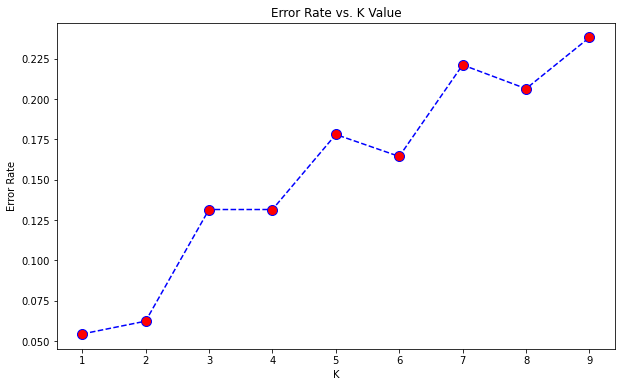

In [ ]:
# show the accuracy in the train data
print(X_train.shape)
print(X_test.shape)
print(len(error_rate))
#Elbow Method
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 1)
# Fit the classifier to the data
knn.fit(X_train,Y_train)
KNN_pred=knn.predict(X_test)
KNN_accuracy = accuracy_score(Y_test, KNN_pred)
print(KNN_accuracy)

0.9455782312925171


In [ ]:
#Grid search:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
  
# defining parameter range
#create a dictionary of all values we want to test for n_neighbors

# uniform' : uniform weights.  All points in each neighborhood
# are weighted equally.

# 'distance' : weight points by the inverse of their distance.
# in this case, closer neighbors of a query point will have a
# greater influence than neighbors which are further away.
# Algorithm used to compute the nearest neighbors:
# 'ball_tree' will use BallTree
# 'kd_tree' will use KDTree
# 'brute' will use a brute-force search.
# 'auto' will attempt to decide the most appropriate algorithm
# based on the values passed to fit method.
#  Leaf size passed to BallTree or KDTree.  This can affect the
# speed of the construction and query, as well as the memory
# required to store the tree.  The optimal value depends on the
# nature of the problem.

weightss=['uniform','distance']
Algo=['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_=[2,10,20,30,40]
param_grid = dict(weights=weightss,n_neighbors= np.arange(1, 4),algorithm=Algo,leaf_size=leaf_)

kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1,scoring="accuracy",cv=kf)
  
# fitting the model for grid search
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=2, n_neighbors=1)
0.9792500000000001


In [ ]:
grid_predictions = grid.predict(X_test)
grid_p_train = grid.predict(X_train)
print('On Train')
print("Accuracy",accuracy_score(Y_train,grid_p_train))
print("F1-Score",f1_score(Y_train,grid_p_train))
print("Precision",precision_score(Y_train,grid_p_train))
print("Recall",recall_score(Y_train,grid_p_train))


print('On Test')
print("Accuracy",accuracy_score(Y_test,grid_predictions))
print("F1-Score",f1_score(Y_test,grid_predictions))
print("Precision",precision_score(Y_test,grid_predictions))
print("Recall",recall_score(Y_test,grid_predictions))
#Checking performance our model with ROC Score.
print('roc_auc_score',roc_auc_score(Y_test, grid_predictions))
# print classification report
print(classification_report(Y_test, grid_predictions))

# without scaling
# On Train
# Accuracy 1.0
# F1-Score 1.0
# Precision 1.0 
# Recall 1.0
# On Test/////////////////////////////
# Accuracy 0.953514739229025
# F1-Score 0.8681672025723473
# Precision 0.7848837209302325
# Recall 0.9712230215827338
# roc_auc_score 0.960712452917881


On Train
Accuracy 1.0
F1-Score 1.0
Precision 1.0
Recall 1.0
On Test
Accuracy 0.9455782312925171
F1-Score 0.8545454545454545
Precision 0.7704918032786885
Recall 0.9591836734693877
roc_auc_score 0.9510204081632652
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97       735
         1.0       0.77      0.96      0.85       147

    accuracy                           0.95       882
   macro avg       0.88      0.95      0.91       882
weighted avg       0.95      0.95      0.95       882



No Skill: ROC AUC=0.500
KNN: ROC AUC=0.951


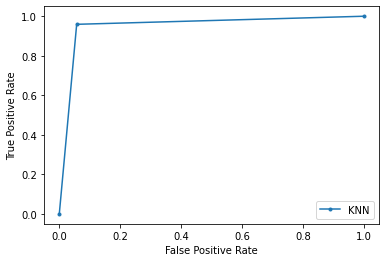

In [ ]:


precision , recall,threshold=precision_recall_curve(Y_test,grid.predict_proba(X_test)[:,1])
F1 = 2 * (precision * recall) / (precision + recall)
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)           ## No skill
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model

plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Best Threshold=1.000000, F-Score=0.855


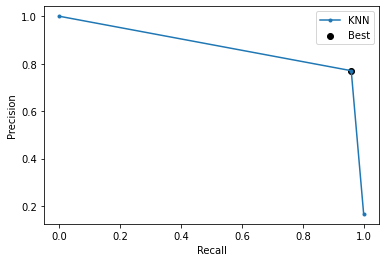

In [ ]:
#Precion Recall Curve
# optimal threshold for precision-recall curve with
yhat = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
i_arx = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i_arx], fscore[i_arx]))
# plot the roc curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',label='KNN')
plt.scatter(recall[i_arx], precision[i_arx], color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

**KNN Model Using Feature_Selection**

In [ ]:
X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
#Make Scaling for X_train 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.fit_transform(X_train[[  'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked', 'Age','Days off']])

X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.transform(X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']])

X_test.shape

(882, 50)

In [ ]:
# This is an important step in the process of a Machine Learning project, it’s also a part of feature engineering Feature Selection
from sklearn.feature_selection import SelectFromModel 
from sklearn import tree
import sklearn.feature_selection as fs


print("The original data")
print(X_train.shape)
# X is you feature matrix
var = fs.VarianceThreshold(threshold=0.2)
var.fit(X_train)
X_train = var.transform(X_train)

# print(X_train.columns[(X_trans)])


print("The processed data by variance threshold")
print(X_train.shape)







The original data
(4000, 50)
The processed data by variance threshold
(4000, 30)


In [ ]:
X_test = var.transform(X_test)
print(X_test.shape)

(882, 30)


In [ ]:
#Grid search:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
  
print(X_train.shape)
print(X_test.shape)

# defining parameter range
#create a dictionary of all values we want to test for n_neighbors
weightss=['uniform','distance']
Algo=['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_=[2,10,20,30,40]
param_grid = dict(weights=weightss,n_neighbors= np.arange(1, 4),algorithm=Algo,leaf_size=leaf_)

kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

gridSC_ = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1,scoring="accuracy",cv=kf)
  
# fitting the model for grid search
gridSC_.fit(X_train, Y_train)
print(gridSC_.best_params_)
print(gridSC_.best_estimator_)
print(gridSC_.best_score_)

(4000, 30)
(882, 30)
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=2, n_neighbors=1)
0.9807500000000001


In [ ]:
grid_predictions = gridSC_.predict(X_test)
print("Accuracy",accuracy_score(Y_test,grid_predictions))
print("F1-Score",f1_score(Y_test,grid_predictions))
print("Precision",precision_score(Y_test,grid_predictions))
print("Recall",recall_score(Y_test,grid_predictions))
# print classification report
print(classification_report(Y_test, grid_predictions))
print(roc_auc_score(Y_test, grid_predictions))


# # when i use the Variance Threshold number of feature the accuracy less than when use all features
#  Accuracy 0.9126984126984127
# F1-Score 0.7475409836065573
# Precision 0.6298342541436464
# Recall 0.9193548387096774
# # let's try when i use selectKBest 

Accuracy 0.9421768707482994
F1-Score 0.8468468468468467
Precision 0.7580645161290323
Recall 0.9591836734693877
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       735
         1.0       0.76      0.96      0.85       147

    accuracy                           0.94       882
   macro avg       0.87      0.95      0.91       882
weighted avg       0.95      0.94      0.94       882

0.9489795918367347


In [ ]:
print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(882, 30)
(4000, 30)
(4000,)


**KNN Model Using Feature Selection**

In [ ]:
X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
#Make Scaling for X_train 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.fit_transform(X_train[[  'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked', 'Age','Days off']])

X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']] = scaler.transform(X_test[[ 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Average hours worked',  'Age','Days off']])

X_test.shape

(882, 50)

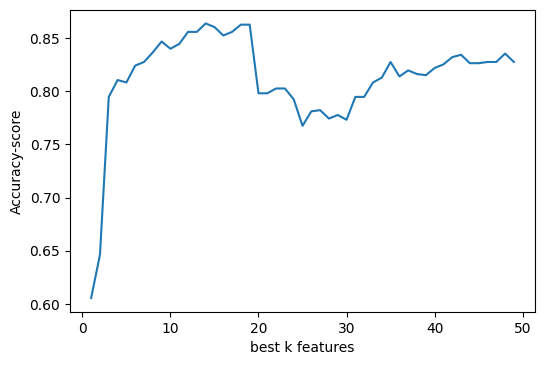

In [ ]:
# another way to make Feature Selection using Select KBEST
import sklearn.feature_selection as fs
import sklearn.datasets as datasets
import sklearn.metrics as metrics
from sklearn.feature_selection import f_classif,SelectKBest



listt = []
for k in range(1, 50):
  bk = SelectKBest(score_func= f_classif, k=k)
  bk.fit(X_train, Y_train)
  X_z= bk.transform(X_train)
  X_t=bk.transform(X_test)
  


  lr = KNeighborsClassifier()
  lr.fit(X_z, Y_train)
  y_pred = lr.predict(X_t)
  # f1 = metrics.f1_score(test_y, y_pred)
  acc=accuracy_score(Y_test,y_pred)
  listt.append(acc)

fig, axe = plt.subplots(dpi = 100)
axe.plot(range(1, 50), listt)
axe.set_xlabel("best k features")
axe.set_ylabel("Accuracy-score")
# fig.savefig("output/img.png")
plt.show()



In [ ]:
#choose from the preivouse graph theK=20
bk = SelectKBest(score_func= f_classif, k=20)
bk.fit(X_train, Y_train)
X_train= bk.transform(X_train)
X_test=bk.transform(X_test)

print(X_train.shape)
print(X_test.shape)

#Print the Accuracy on Train Data to check it with Test Data
  # Create KNN classifier
# knn = KNeighborsClassifier(n_neighbors = 1)
# # Fit the classifier to the data
# knn.fit(X_train,Y_train)
# KNN_pred_train=knn.predict(X_train)
# KNN_accuracy_train = accuracy_score(Y_train, KNN_pred_train)
# print("Accuracy of Train",KNN_accuracy_train)  

#make GridSearch
# #Grid search:


# defining parameter range
#create a dictionary of all values we want to test for n_neighbors
weightss=['uniform','distance']
Algo=['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_=[2,4,6,8,10]
param_grid = dict(weights=weightss,n_neighbors= np.arange(1, 4),algorithm=Algo,leaf_size=leaf_)

kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

gridSC_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1,scoring="accuracy",cv=kf)
  
# fitting the model for grid search
gridSC_KNN.fit(X_train, Y_train)
KNN_pred_train=gridSC_KNN.predict(X_train)
print(gridSC_KNN.best_params_)
print(gridSC_KNN.best_estimator_)
print(gridSC_KNN.best_score_)

  # Create KNN classifier
  #Test -- Test data
# KNN_pred=knn.predict(X_test)
# KNN_accuracy = accuracy_score(Y_test, KNN_pred)
# print('Accuracy of Test',KNN_accuracy)

(4000, 20)
(882, 20)
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=2, n_neighbors=1)
0.9770000000000001


In [ ]:
grid_train = gridSC_KNN.predict(X_train)
print("ON Train")
print("Accuracy",accuracy_score(Y_train,grid_train))
print("F1-Score",f1_score(Y_train,grid_train))
print("Precision",precision_score(Y_train,grid_train))
print("Recall",recall_score(Y_train,grid_train))
print("ON TEST")
grid_predictions = gridSC_KNN.predict(X_test)
print("Accuracy",accuracy_score(Y_test,grid_predictions))
print("F1-Score",f1_score(Y_test,grid_predictions))
print("Precision",precision_score(Y_test,grid_predictions))
print("Recall",recall_score(Y_test,grid_predictions))
# print classification report
print(classification_report(Y_test, grid_predictions))
print(roc_auc_score(Y_test, grid_predictions))  # the accuracy  better than  when i use all features when i use the KNN model

# when i use SelectKBest the accuracy and f1 and precision and recall increase that mean the selectfromModel Get The best Features  

ON Train
Accuracy 1.0
F1-Score 1.0
Precision 1.0
Recall 1.0
ON TEST
Accuracy 0.9421768707482994
F1-Score 0.8360128617363344
Precision 0.7558139534883721
Recall 0.935251798561151
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       743
         1.0       0.76      0.94      0.84       139

    accuracy                           0.94       882
   macro avg       0.87      0.94      0.90       882
weighted avg       0.95      0.94      0.94       882

0.9393621038566186


In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=1,weights='uniform',algorithm='auto',leaf_size=2)
knn_final.fit(X_train,Y_train)
pred=knn_final.predict(X_test)
Score=accuracy_score(Y_test,pred)
print(Score)
# the accuracy not better so i use all features when i use the KNN model

# when i use SelectKBest the accuracy and f1 and precision and recall increase that mean the all features Get The best Features  

0.9160997732426304


# Decision Tree Model

---
Without FeatureSelection


---



In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


(4000, 50)
(882, 50)
Time to fit Model 0.032453298568725586


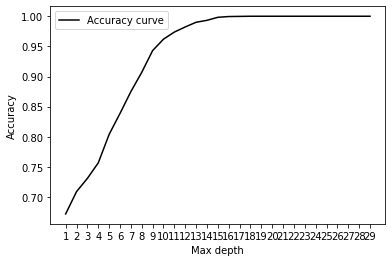

In [ ]:
print(X_train.shape)
print(X_test.shape)
# show the accuracy in the train data
Accuracy_Score=[]
Level=[]
for i in range(1,30):
    Start_time = time.time()
    Dectree_model_train = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    
   
    #prediction for X_Train
    Y_Pred_train = Dectree_model_train.predict(X_train)
    #print(Y_Pred)
    # show the Accuracy of Y_train with Y_predaction
    Accuracy_Score.append(accuracy_score(Y_train, Y_Pred_train))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,Accuracy_Score,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()



Time to fit Model 0.03750491142272949


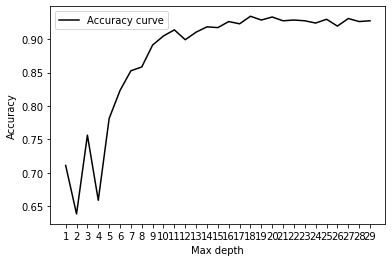

In [ ]:
#show the accuracy in test data
accuracy=[]
Level=[]

for i in range(1,30):
    Start_time = time.time()
    Dectree_model = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    #prediction for X_Test
    Y_Pred = Dectree_model.predict(X_test)
    #print(Y_Pred)
    # show the Accuracy of Y_Test with Y_predaction
    accuracy.append(accuracy_score(Y_test, Y_Pred))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,accuracy,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
# From the pervious graph we show the max depth and the accuracy so 
# now we can choose the suitable depth to get max accuracy  because when increase the depth increase the overfitting
for i in range(1,30):
    Start_time = time.time()
    Dectree_model = DecisionTreeClassifier(max_depth = i,splitter='best',criterion='gini').fit(X_train, Y_train)
    End_time = time.time()
    Y_Pred = Dectree_model.predict(X_test)
    print("Accuracy with each level = ",i,"is: ",accuracy_score(Y_test, Y_Pred))
Time=End_time-Start_time
print("Time Take to fit the model" , Time)


Accuracy with each level =  1 is:  0.7108843537414966
Accuracy with each level =  2 is:  0.6383219954648526
Accuracy with each level =  3 is:  0.7562358276643991
Accuracy with each level =  4 is:  0.6587301587301587
Accuracy with each level =  5 is:  0.7811791383219955
Accuracy with each level =  6 is:  0.8219954648526077
Accuracy with each level =  7 is:  0.8514739229024944
Accuracy with each level =  8 is:  0.8662131519274376
Accuracy with each level =  9 is:  0.891156462585034
Accuracy with each level =  10 is:  0.9070294784580499
Accuracy with each level =  11 is:  0.9160997732426304
Accuracy with each level =  12 is:  0.9002267573696145
Accuracy with each level =  13 is:  0.9172335600907029
Accuracy with each level =  14 is:  0.9217687074829932
Accuracy with each level =  15 is:  0.9217687074829932
Accuracy with each level =  16 is:  0.9183673469387755
Accuracy with each level =  17 is:  0.9263038548752834
Accuracy with each level =  18 is:  0.9331065759637188
Accuracy with each l

In [ ]:
#Make GridSearch Using KFold specified StratifiedKFold To show the Best Sore with The best Parametres
from sklearn import decomposition, datasets

l=['sqrt','log2',None]
l_splitter=['best','random']
l_criterion=['gini','entropy']

#pca__n_components=n_components,  to try the best number of components
# n_componentss = list(range(1,X.shape[1]+1,1))
# pca = decomposition.PCA(n_components=n_componentss)
parameters = dict(criterion=l_criterion,splitter=l_splitter,max_depth=range(1,20),max_features=l)
kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = GridSearchCV(DecisionTreeClassifier(),param_grid= parameters, n_jobs=-1,cv=kf,scoring='f1')
# tree_model = clf.best_estimator_
clf_save=clf.fit(X_train,Y_train)
print (clf.best_score_, clf.best_params_) 

0.9805387504238079 {'criterion': 'gini', 'max_depth': 19, 'max_features': None, 'splitter': 'random'}


In [ ]:
grid_predictions = clf.predict(X_test)
print("Accuracy",accuracy_score(Y_test,grid_predictions))
print("F1-Score",f1_score(Y_test,grid_predictions))
print("Precision",precision_score(Y_test,grid_predictions))
print("Recall",recall_score(Y_test,grid_predictions))
# print classification report
print(classification_report(Y_test, grid_predictions))
#Checking performance our model with ROC Score.
print(roc_auc_score(Y_test, grid_predictions))
# cm=cross_val_predict(clf,X_test,Y_test,cv=10)
# print(confusion_matrix(Y_test,cm))
print(confusion_matrix(Y_test,grid_predictions))


Accuracy 0.9240362811791383
F1-Score 0.8069164265129684
Precision 0.7
Recall 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       735
         1.0       0.70      0.95      0.81       147

    accuracy                           0.92       882
   macro avg       0.84      0.94      0.88       882
weighted avg       0.94      0.92      0.93       882

0.9353741496598639
[[675  60]
 [  7 140]]
19


In [ ]:
# grid_train = clf.predict(X_train)
# print("Accuracy",accuracy_score(Y_train,grid_train))
# print("F1-Score",f1_score(Y_train,grid_train))
# print("Precision",precision_score(Y_train,grid_train))
# print("Recall",recall_score(Y_train,grid_train))

Accuracy 1.0
F1-Score 1.0
Precision 1.0
Recall 1.0


In [ ]:
#Sore on the training Data
Dectree_model = DecisionTreeClassifier(max_depth = 19,max_features='auto',splitter='best',criterion='gini').fit(X_train, Y_train)
Train_Y_pred = Dectree_model.predict(X_train)
score=accuracy_score(Y_train,Train_Y_pred)
print(score)
score_pre=precision_score(Y_train,Train_Y_pred)
print(score_pre)

0.99925
0.9985022466300549


In [ ]:
#Sore on the Testing Data using Max Feature sqrtfor(all features)
# Dectree_model_model = DecisionTreeClassifier(max_depth = 18,max_features='sqrt',splitter='best',criterion='gini').fit(X_train, Y_train)
Y_Pred = Dectree_model.predict(X_test)
score=accuracy_score(Y_test,Y_Pred)
print(score)
score_pre=precision_score(Y_test,Y_Pred)  #0.5876777251184834
print(score_pre)


0.9206349206349206
0.7037037037037037


No Skill: ROC AUC=0.500
Decision tree: ROC AUC=0.916


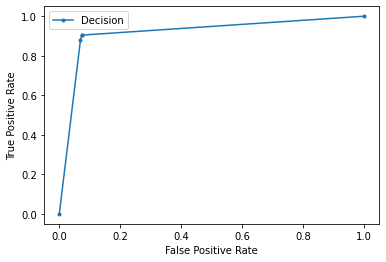

In [ ]:


precision , recall,threshold=precision_recall_curve(Y_test,Dectree_model.predict_proba(X_test)[:,1])
F1 = 2 * (precision * recall) / (precision + recall)
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = Dectree_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)           ## No skill
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision tree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model

plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Best Threshold=0.955556, F-Score=0.796


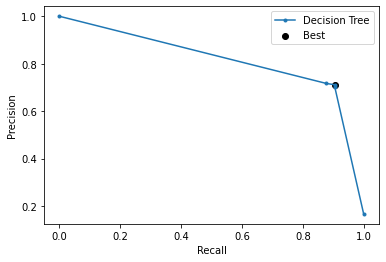

In [ ]:
#Precion Recall Curve
# optimal threshold for precision-recall curve with logistic regression model

yhat = Dectree_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
i_arx = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i_arx], fscore[i_arx]))
# plot the roc curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',label='Decision Tree')
plt.scatter(recall[i_arx], precision[i_arx], color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

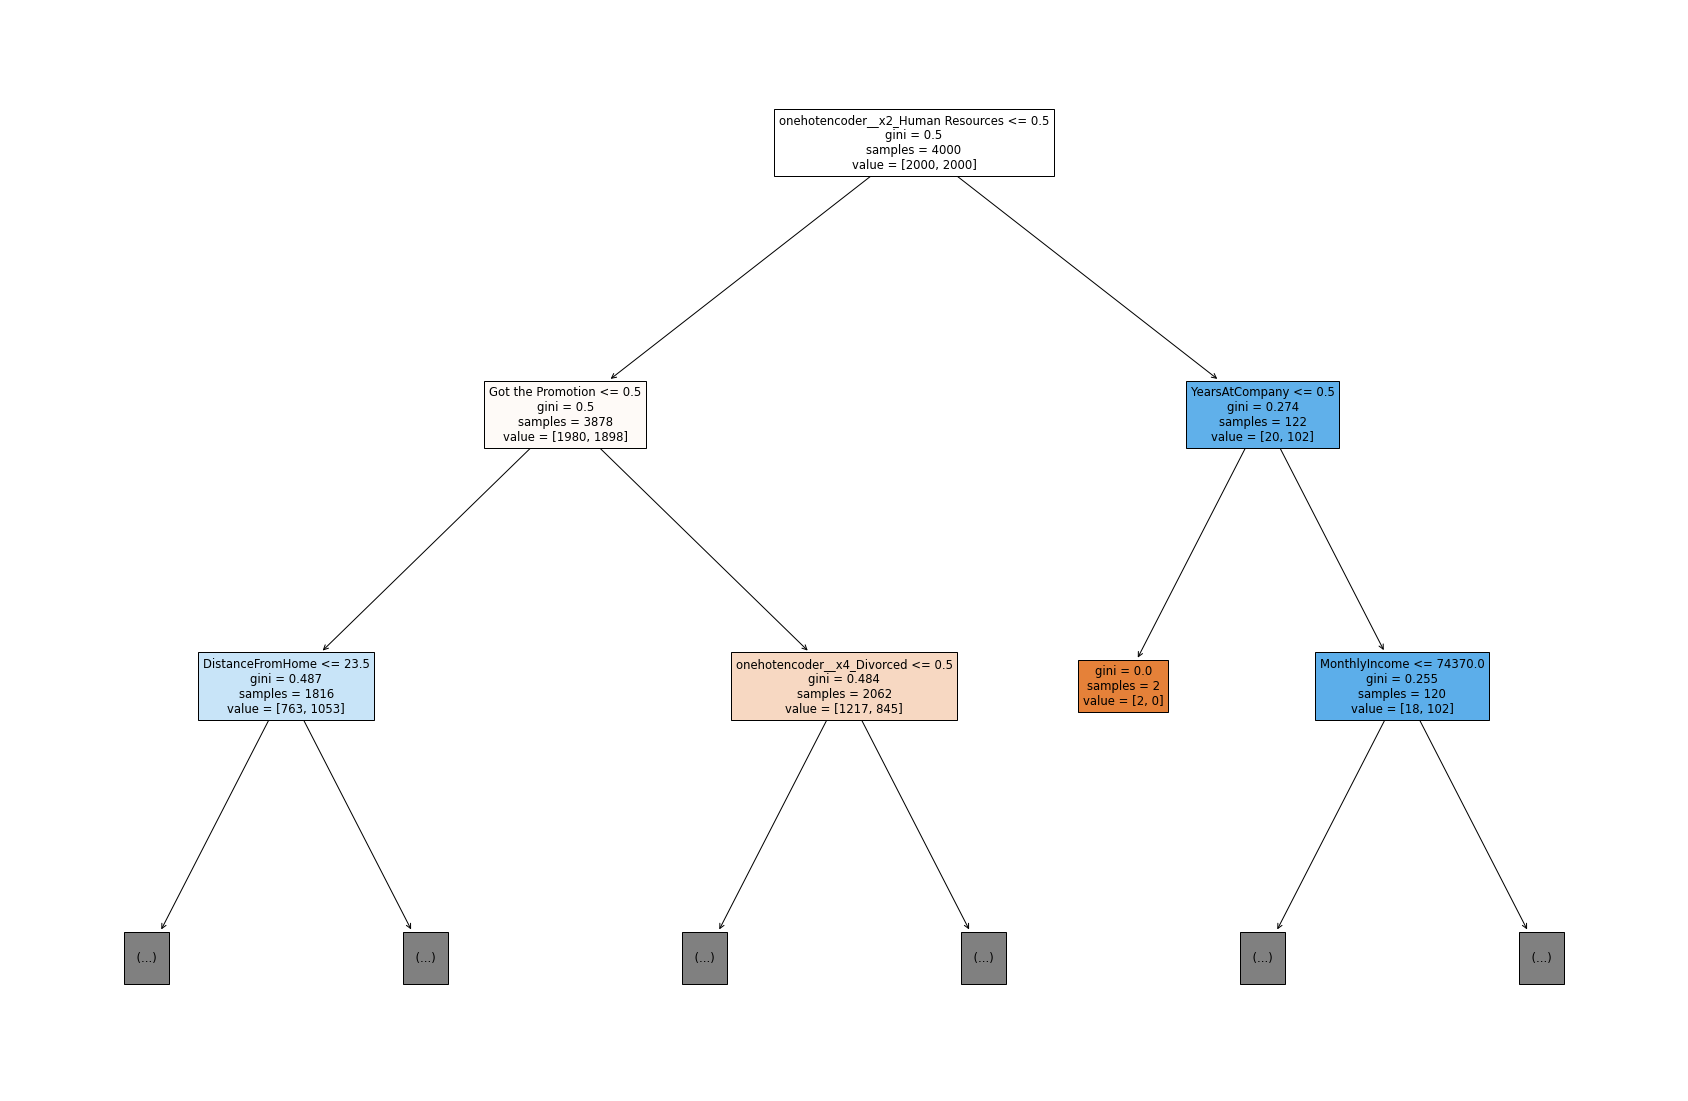

In [ ]:
from sklearn import tree
feature_names = list(X_train.columns)
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(Dectree_model,max_depth=2, 
                   feature_names=feature_names,  
                   filled=True)


# Decision Tree Model
# using Feature_Selection

In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
# This is an important step in the process of a Machine Learning project, it’s also a part of feature engineering Feature Selection
from sklearn.feature_selection import SelectFromModel 
from sklearn import tree
import sklearn.feature_selection as fs

# variance Thresholding is that the features with low variance are less likely to be useful than features with high variance. In variance Thresholding,
# we first calculates the variance of each features and then drops all features which variance does not meet that threshold.

print("The original data")
print(X_train.shape)
# X is you feature matrix
var = fs.VarianceThreshold(threshold=0.2)
var.fit(X_train)
X_train = var.transform(X_train)
X_test = var.transform(X_test)
# print(X_train.columns[(X_trans)])
print("The processed data by variance threshold")
print(X_train.shape)




The original data
(4000, 30)
The processed data by variance threshold
(4000, 30)


(4000, 30)
(882, 30)
Time to fit Model 0.024394750595092773


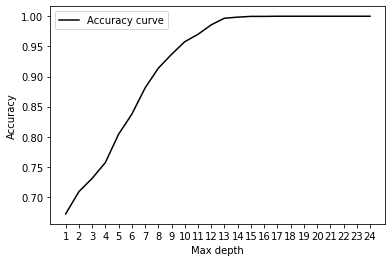

In [ ]:
print(X_train.shape)
print(X_test.shape)
# show the accuracy in the train data
Accuracy_Score=[]
Level=[]
for i in range(1,25):
    Start_time = time.time()
    Dectree_model_train = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    
    # scores = cross_val_score(estimator=clf, X=x, y=y, cv=7, n_jobs=4)
    #prediction for X_Train
    Y_Pred_train = Dectree_model_train.predict(X_train)
    #print(Y_Pred)
    # show the Accuracy of Y_train with Y_predaction
    Accuracy_Score.append(accuracy_score(Y_train, Y_Pred_train))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,Accuracy_Score,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()



Time to fit Model 0.024493694305419922


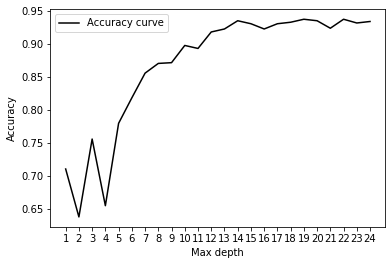

In [ ]:
#show the accuracy in test data
accuracy=[]
Level=[]

for i in range(1,25):
    Start_time = time.time()
    Dectree_model = DecisionTreeClassifier(max_depth = i).fit(X_train, Y_train)
    End_time = time.time()
    #prediction for X_Test
    Y_Pred = Dectree_model.predict(X_test)
    #print(Y_Pred)
    # show the Accuracy of Y_Test with Y_predaction
    accuracy.append(accuracy_score(Y_test, Y_Pred))
    Level.append(i)
print("Time to fit Model", (End_time-Start_time))    
plt.plot(Level,accuracy,color = 'black', label = 'Accuracy curve')
plt.xticks(Level)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
#Make GridSearch Using KFold specified StratifiedKFold To show the Best Sore with The best Parametres
from sklearn import decomposition, datasets

l=['sqrt','log2',None]
l_splitter=['best','random']
l_criterion=['gini','entropy']

parameters = dict(criterion=l_criterion,splitter=l_splitter,max_depth=range(1,20),max_features=l)
kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf_DEC = GridSearchCV(DecisionTreeClassifier(),param_grid= parameters, n_jobs=-1,cv=kf,scoring='accuracy')
# tree_model = clf.best_estimator_
clf_save=clf_DEC.fit(X_train,Y_train)
print (clf.best_score_, clf.best_params_) 

0.9805387504238079 {'criterion': 'gini', 'max_depth': 19, 'max_features': None, 'splitter': 'random'}


In [ ]:
grid_predictions_Dec = clf_DEC.predict(X_test)
gDec = clf_DEC.predict(X_train)

# print('On train')
# print("Accuracy",accuracy_score(Y_train,gDec))
# print("F1-Score",f1_score(Y_train,gDec))
# print("Precision",precision_score(Y_train,gDec))
# print("Recall",recall_score(Y_train,gDec))

print("On Test")
print("Accuracy",accuracy_score(Y_test,grid_predictions_Dec))
print("F1-Score",f1_score(Y_test,grid_predictions_Dec))
print("Precision",precision_score(Y_test,grid_predictions_Dec))
print("Recall",recall_score(Y_test,grid_predictions_Dec))
# print classification report
print(classification_report(Y_test, grid_predictions_Dec))
#Checking performance our model with ROC Score.
print(roc_auc_score(Y_test, grid_predictions_Dec))
# cm=cross_val_predict(clf,X_test,Y_test,cv=10)
# print(confusion_matrix(Y_test,cm))
print(confusion_matrix(Y_test,grid_predictions_Dec))


#Accuracy 0.9240362811791383
# F1-Score 0.8069164265129684
# Precision 0.7
# Recall 0.9523809523809523                  # This all Accuracy on the All Features


# when i make a feature selection using VarianceThreshold the All Acc increase to

# On Test
# Accuracy 0.927437641723356
# F1-Score 0.8106508875739645
# Precision 0.7172774869109948
# Recall 0.9319727891156463



On Test
Accuracy 0.927437641723356
F1-Score 0.8106508875739645
Precision 0.7172774869109948
Recall 0.9319727891156463
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       735
         1.0       0.72      0.93      0.81       147

    accuracy                           0.93       882
   macro avg       0.85      0.93      0.88       882
weighted avg       0.94      0.93      0.93       882

0.9292517006802721
[[681  54]
 [ 10 137]]


In [ ]:
#Sore on the training Data
Dectree_model__ = DecisionTreeClassifier(max_depth = 19,max_features=None,splitter='random',criterion='gini').fit(X_train, Y_train)
Train_Y_pred = Dectree_model.predict(X_train)
score=accuracy_score(Y_train,Train_Y_pred)
print(score)

1.0


In [ ]:
#Sore on the Testing Data using Max Feature sqrtfor(all features)
# Dectree_model_model = DecisionTreeClassifier(max_depth = 15,max_features='sqrt',splitter='best',criterion='gini').fit(x_train, y_train)
Y_Pred = Dectree_model__.predict(X_test)
score=accuracy_score(Y_test,Y_Pred)
print(score)

0.9319727891156463


No Skill: ROC AUC=0.500
Decision tree: ROC AUC=0.937


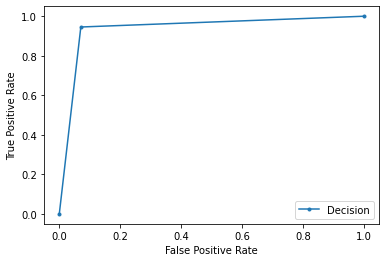

In [ ]:


precision , recall,threshold=precision_recall_curve(Y_test,Dectree_model__.predict_proba(X_test)[:,1])
F1 = 2 * (precision * recall) / (precision + recall)
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = Dectree_model__.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)           ## No skill
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision tree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model

plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Best Threshold=1.000000, F-Score=0.822


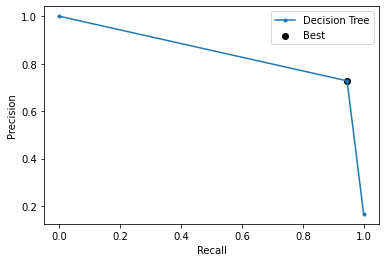

In [ ]:
#Precion Recall Curve
# optimal threshold for precision-recall curve with Dec model

yhat = Dectree_model__.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
i_arx = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i_arx], fscore[i_arx]))
# plot the roc curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',label='Decision Tree')
plt.scatter(recall[i_arx], precision[i_arx], color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
# filename = 'Dectree_model.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# result

**SelectKBest**

In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


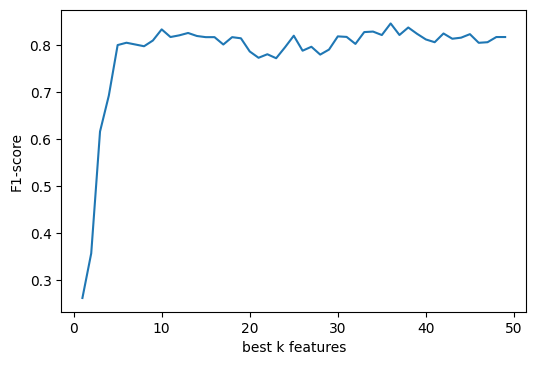

In [ ]:
import sklearn.feature_selection as fs
import sklearn.datasets as datasets
import sklearn.metrics as metrics
from sklearn.feature_selection import f_classif,SelectKBest
f1_list=[]
for k in range(1, 50):
    bk = SelectKBest(score_func= f_classif, k=k)
    bk.fit(X_train, Y_train)
    X_trans = bk.transform(X_train)
    X_trest=bk.transform(X_test)
    
    
    lr = DecisionTreeClassifier()
    lr.fit(X_trans, Y_train)
    y_pred = lr.predict(X_trest)
    f1 = metrics.f1_score(Y_test, y_pred)
    f1_list.append(f1)

fig, axe = plt.subplots(dpi = 100)
axe.plot(range(1, 50), f1_list)
axe.set_xlabel("best k features")
axe.set_ylabel("F1-score")
plt.show()

In [ ]:
bk = SelectKBest(score_func= f_classif, k=20)
bk.fit(X_train, Y_train)
X_train = bk.transform(X_train)
X_test=bk.transform(X_test)
print(X_train.shape)
print(X_test.shape)

#Print the Accuracy on Train Data to check it with Test Data
  # Create Decisiontree classifier
Dec = DecisionTreeClassifier(max_depth = 18,max_features='sqrt',splitter='random',criterion='gini')
# Fit the classifier to the data
Dec.fit(X_train,Y_train)
Y_pred_t = Dec.predict(X_train)
accuracy_ = accuracy_score(Y_train, Y_pred_t)
print("Accuracy of Train",accuracy_)  
  # Create KNN classifier
  #Test -- Test data
Y_pred=Dec.predict(X_test)
Dec_accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy of Test',Dec_accuracy)

(4000, 20)
(882, 20)
Accuracy of Train 0.999
Accuracy of Test 0.9115646258503401


In [ ]:
grid_predictions = Dec.predict(X_test)
# print('On Train')
# train_pred= Dec.predict(X_train)
# print("Accuracy",accuracy_score(Y_train,train_pred))
# print("F1-Score",f1_score(Y_train,train_pred))
# print("Precision",precision_score(Y_train,train_pred))
# print("Recall",recall_score(Y_train,train_pred))
# # print classification report

print("ON test")
print("Accuracy",accuracy_score(Y_test,grid_predictions))
print("F1-Score",f1_score(Y_test,grid_predictions))
print("Precision",precision_score(Y_test,grid_predictions))
print("Recall",recall_score(Y_test,grid_predictions))
# print classification report
print(classification_report(Y_test, grid_predictions))
#Checking performance our model with ROC Score.
print(roc_auc_score(Y_test, grid_predictions))
# # cm=cross_val_predict(clf,X_test,Y_test,cv=10)
# print(confusion_matrix(Y_test,cm))
print(confusion_matrix(Y_test,grid_predictions))


# Accuracy 0.8752834467120182
# F1-Score 0.6892655367231638
# Precision 0.5700934579439252
# Recall 0.8714285714285714                     # This all Accuracy on the All Features


# when i make a feature selection using VarianceThreshold the All Acc increase to

# On Test
# Accuracy 0.927437641723356
# F1-Score 0.8106508875739645
# Precision 0.7172774869109948
# Recall 0.9319727891156463
# when i use SelectKBest the ACC increase 
# Accuracy 0.9115646258503401
# F1-Score 0.7745664739884393
# Precision 0.6733668341708543
# Recall 0.9115646258503401
# Let's try the final way SelectFromModel
              

ON test
Accuracy 0.9115646258503401
F1-Score 0.7745664739884393
Precision 0.6733668341708543
Recall 0.9115646258503401
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       735
         1.0       0.67      0.91      0.77       147

    accuracy                           0.91       882
   macro avg       0.83      0.91      0.86       882
weighted avg       0.93      0.91      0.92       882

0.9115646258503401
[[670  65]
 [ 13 134]]


In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn import tree

half_selector = SelectFromModel(estimator=DecisionTreeClassifier(max_depth=18),)
_= half_selector.fit(X_train, Y_train)
half_selector.get_support
half_selector.estimator_.feature_importances_
selected_feat= X_train.columns[(half_selector.get_support())]
  #print(half_selector.estimator_.feature_importances_)
  #print(len((half_selector.estimator_.feature_importances_)))
print(len(selected_feat) ,"And ",)
print(selected_feat)
X_train = pd.DataFrame(X_train, columns=selected_feat)
X_test=pd.DataFrame(X_test, columns=selected_feat)

15 And 
Index(['onehotencoder__x4_Single', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsWithCurrManager', 'Average hours worked'],
      dtype='object')


In [ ]:
#Make GridSearch Using KFold specified StratifiedKFold To show the Best Sore with The best Parametres
from sklearn import decomposition, datasets

l=['sqrt','log2',None,]
l_splitter=['best','random']
l_criterion=['gini','entropy']
depth=range(1,20)
#pca__n_components=n_components,  to try the best number of components
# n_componentss = list(range(1,X.shape[1]+1,1))
# pca = decomposition.PCA(n_components=n_componentss)
parameters = dict(criterion=l_criterion,splitter=l_splitter,max_depth=depth,max_features=l)
kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = GridSearchCV(DecisionTreeClassifier(),param_grid= parameters, n_jobs=-1,cv=kf,scoring='accuracy')
# tree_model = clf.best_estimator_
clf_save=clf.fit(X_train,Y_train)
print (clf.best_score_, clf.best_params_) 

0.9842500000000001 {'criterion': 'gini', 'max_depth': 19, 'max_features': None, 'splitter': 'random'}


In [ ]:
pred=clf.predict(X_test)
print("Accuracy",accuracy_score(Y_test,pred))
print("F1-Score",f1_score(Y_test,pred))
print("Precision",precision_score(Y_test,pred))
print("Recall",recall_score(Y_test,pred))
print("ROC_AUC_Score",roc_auc_score(Y_test, grid_predictions))
# print classification report
print(classification_report(Y_test, pred))

# cm=cross_val_predict(clf,X_test,Y_test,cv=10)
# print(confusion_matrix(Y_test,cm))
print(confusion_matrix(Y_test,grid_predictions))

Accuracy 0.9512471655328798
F1-Score 0.865203761755486
Precision 0.8023255813953488
Recall 0.9387755102040817
ROC_AUC_Score 0.9115646258503401
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       735
         1.0       0.80      0.94      0.87       147

    accuracy                           0.95       882
   macro avg       0.89      0.95      0.92       882
weighted avg       0.96      0.95      0.95       882

[[670  65]
 [ 13 134]]


In [ ]:
Dec = DecisionTreeClassifier(max_depth = 12,max_features=None,splitter='random',criterion='gini')
# Fit the classifier to the data
Dec.fit(X_train,Y_train)
Y_pred_t = Dec.predict(X_train)
accuracy_ = accuracy_score(Y_train, Y_pred_t)
print("Accuracy of Train",accuracy_)  
  # Create KNN classifier
  #Test -- Test data
Y_pred=Dec.predict(X_test)
Dec_accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy of Test',Dec_accuracy)

Accuracy of Train 0.9875
Accuracy of Test 0.9410430839002267


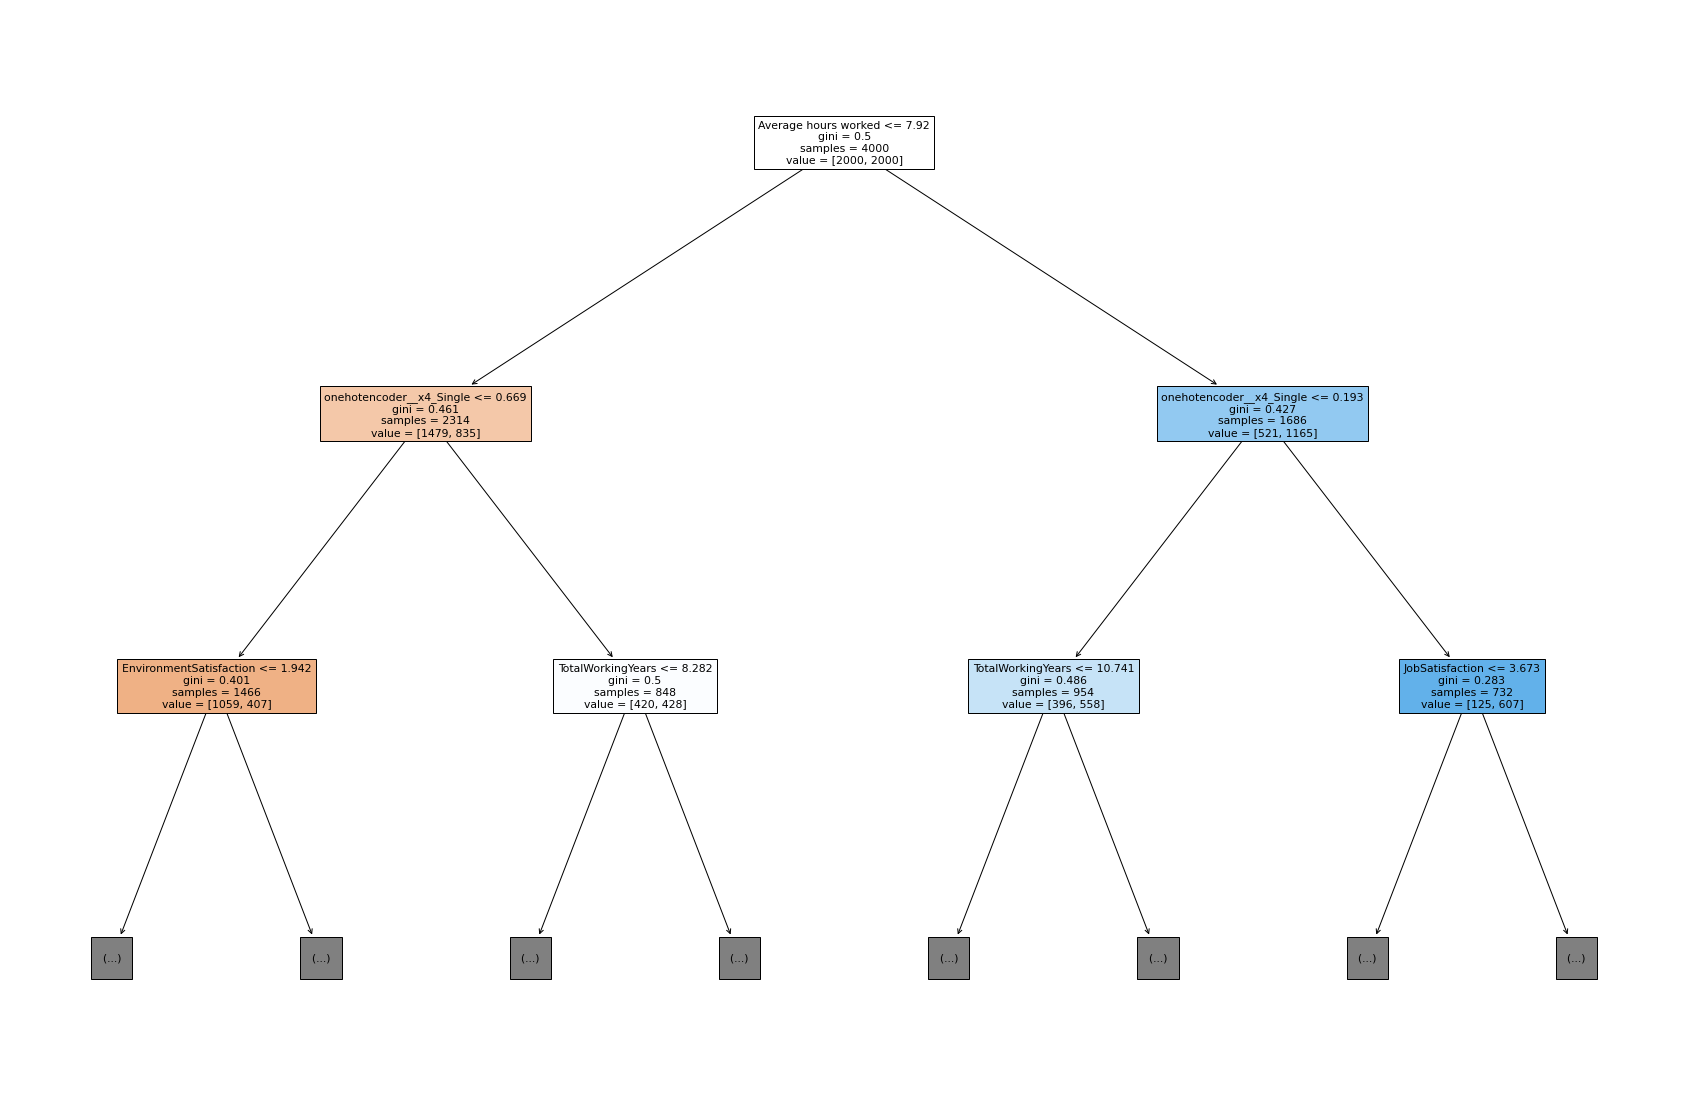

In [ ]:
feature_names = list(X_train.columns)
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(Dec,max_depth=2, 
                   feature_names=feature_names,  
                   filled=True)

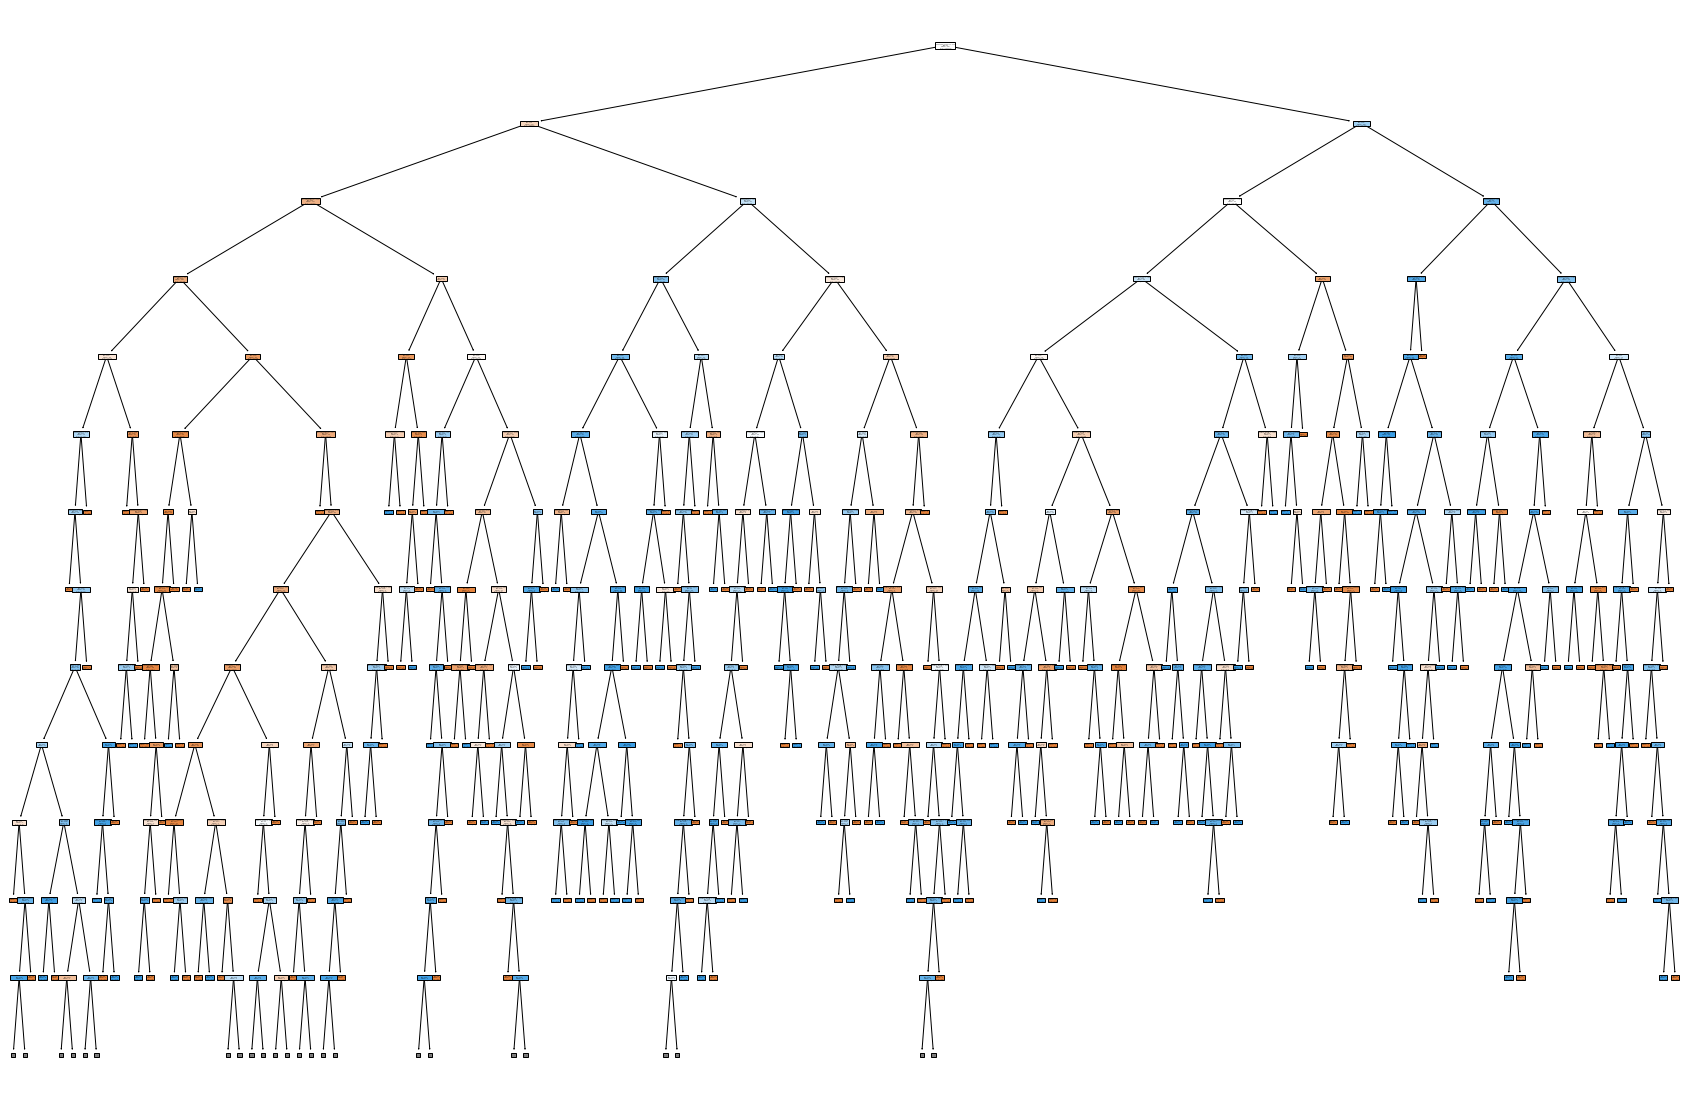

In [ ]:
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(Dec,max_depth=12, 
                   feature_names=feature_names,  
                   filled=True)

# **SVM , XGB Model**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
print(X_test.shape)
print(X_train.shape)

# poly = svm.SVC(kernel='poly',gamma=0.1).fit(X_train, Y_train)
# poly_pred = poly.predict(X_test)
# poly_accuracy = accuracy_score(Y_test, poly_pred)
# print(poly_accuracy)
# print(classification_report(Y_test, poly_pred))

# poly = svm.SVC(kernel='poly', degree=3,gamma=0.0001, C=7).fit(X_train, Y_train)
# poly_pred = poly.predict(X_test)
# poly_accuracy = accuracy_score(Y_test, poly_pred)
# print(poly_accuracy)
# print(classification_report(Y_test, poly_pred))

(882, 50)
(4000, 50)


In [ ]:
# the defult kernel in SVC :rbf
# Gamma increase the distance between the Margin and Hyperplane
start = time.time()
rbf = svm.SVC(kernel='rbf', degree=3,gamma=0.0001, C=7).fit(X_train, Y_train)
stop = time.time()
rbf_pred = rbf.predict(X_test)

rbf_ = rbf.predict(X_train)
print('On Train')
print("Accuracy",accuracy_score(Y_train,rbf_))
print("F1-Score",f1_score(Y_train,rbf_))
print("Precision",precision_score(Y_train,rbf_))
print("Recall",recall_score(Y_train,rbf_))
print('On test')
print("Accuracy",accuracy_score(Y_test,rbf_pred))
print("F1-Score",f1_score(Y_test,rbf_pred))
print("Precision",precision_score(Y_test,rbf_pred))
print("Recall",recall_score(Y_test,rbf_pred))
# print classification report
print(classification_report(Y_test, rbf_pred))

On Train
Accuracy 0.98825
F1-Score 0.9883403621930043
Precision 0.9807976366322009
Recall 0.996
On test
Accuracy 0.9036281179138322
F1-Score 0.747774480712166
Precision 0.6631578947368421
Recall 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       735
         1.0       0.66      0.86      0.75       147

    accuracy                           0.90       882
   macro avg       0.82      0.89      0.84       882
weighted avg       0.92      0.90      0.91       882



In [ ]:
Linear = svm.SVC(kernel='linear',gamma=0.0001,degree=3,C=7).fit(X_train, Y_train)
linear_pred = Linear.predict(X_test)
Linear_accuracy = accuracy_score(Y_test, linear_pred)
linear_pred_train = Linear.predict(X_train)

print('on train')
print("Accuracy",accuracy_score(Y_train,linear_pred_train))
print("F1-Score",f1_score(Y_train,linear_pred_train))
print("Precision",precision_score(Y_train,linear_pred_train))
print("Recall",recall_score(Y_train,linear_pred_train))
print('on test')
print("Accuracy",accuracy_score(Y_test,linear_pred))
print("F1-Score",f1_score(Y_test,linear_pred))
print("Precision",precision_score(Y_test,linear_pred))
print("Recall",recall_score(Y_test,linear_pred))
# print classification report
print(classification_report(Y_test, linear_pred))

on train
Accuracy 0.666
F1-Score 0.6727094561489466
Precision 0.659462055715658
Recall 0.6865
on test
Accuracy 0.6190476190476191
F1-Score 0.38235294117647056
Precision 0.2619647355163728
Recall 0.7074829931972789
              precision    recall  f1-score   support

         0.0       0.91      0.60      0.72       735
         1.0       0.26      0.71      0.38       147

    accuracy                           0.62       882
   macro avg       0.59      0.65      0.55       882
weighted avg       0.80      0.62      0.67       882



In [ ]:
# poly = svm.SVC(kernel='poly',gamma=0.1).fit(X_train, Y_train)
# poly_pred = poly.predict(X_test)
# poly_accuracy = accuracy_score(Y_test, poly_pred)
# print(poly_accuracy)
# print(classification_report(Y_test, poly_pred))


In [ ]:
# #Grid search:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
  
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10], 
#               'gamma': [ 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear','poly']} 
# # kf =StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid = RandomizedSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,scoring="accuracy")
  
# # fitting the model for grid search
# grid.fit(X_train, Y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)
# print(grid.best_score_)

#but very slow to run , it take more time to run 

In [ ]:

# grid_predictions = grid.predict(X_test)
  
# # print classification report
# print(classification_report(Y_test, grid_predictions))

In [ ]:
# grid_predictions = clf.predict(X_test)
# print("Accuracy",accuracy_score(Y_test,grid_predictions))
# print("F1-Score",f1_score(Y_test,grid_predictions))
# print("Precision",precision_score(Y_test,grid_predictions))
# print("Recall",recall_score(Y_test,grid_predictions))
# # print classification report
# print(classification_report(Y_test, grid_predictions))
# #Checking performance our model with ROC Score.
# print(roc_auc_score(Y_test, grid_predictions))
# print(confusion_matrix(Y_test,grid_predictions))


In [ ]:
#Curve of ROC & AUC

**GradientBoostingClassifier**

In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, Y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, Y_test)))

Learning rate:  0.05
Accuracy score (training): 0.710
Accuracy score (testing): 0.712
Learning rate:  0.075
Accuracy score (training): 0.710
Accuracy score (testing): 0.709
Learning rate:  0.1
Accuracy score (training): 0.713
Accuracy score (testing): 0.712
Learning rate:  0.25
Accuracy score (training): 0.737
Accuracy score (testing): 0.732
Learning rate:  0.5
Accuracy score (training): 0.749
Accuracy score (testing): 0.745
Learning rate:  0.75
Accuracy score (training): 0.763
Accuracy score (testing): 0.734
Learning rate:  1
Accuracy score (training): 0.764
Accuracy score (testing): 0.752


In [ ]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, Y_train)
predictions_GBC = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions_GBC))

print("Classification Report")
print(classification_report(Y_test, predictions_GBC))




Confusion Matrix:
[[555 180]
 [ 39 108]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84       735
         1.0       0.38      0.73      0.50       147

    accuracy                           0.75       882
   macro avg       0.65      0.74      0.67       882
weighted avg       0.84      0.75      0.78       882



In [ ]:
# gb = GradientBoostingClassifier(n_estimators=20)
# gb.fit(X, Y)
# print("The feature importances of GBDT")
# print(gb.feature_importances_)

# model = fs.SelectFromModel(gb, prefit=True)
# X_transs = model.transform(X)
# print("The shape of original data is {}".format(X.shape))
# print("The shape of transformed data is {}".format(X_transs.shape))

**XGBClassifier**

In [ ]:

X_test=test_df.drop(['Attrition'],axis=1)
Y_test=test_df['Attrition']
# to check if the data balance or Not
print(Y_test.value_counts())
print(X_test.shape)

Data=df_upsampled
X_train=Data.drop(['Attrition'],axis=1)
Y_train=Data['Attrition']
# to check if the data balance or Not
print(Y_train.value_counts())
print(X_train.shape)

0.0    735
1.0    147
Name: Attrition, dtype: int64
(882, 50)
1.0    2000
0.0    2000
Name: Attrition, dtype: int64
(4000, 50)


In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, Y_train)
pred=xgb_clf.predict(X_test)
score = xgb_clf.score(X_test, Y_test)
print(score)

print("Accuracy",accuracy_score(Y_test,pred))
print("F1-Score",f1_score(Y_test,pred))
print("Precision",precision_score(Y_test,pred))
print("Recall",recall_score(Y_test,pred))
# print classification report
print(classification_report(Y_test, pred))

0.8424036281179138
Accuracy 0.8424036281179138
F1-Score 0.6273458445040214
Precision 0.5176991150442478
Recall 0.7959183673469388
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       735
         1.0       0.52      0.80      0.63       147

    accuracy                           0.84       882
   macro avg       0.74      0.82      0.76       882
weighted avg       0.88      0.84      0.85       882



In [ ]:
#GridSearch
# estimator means Number of trees to fit.
# HyperParameters Optimizing 

# 'objective':'reg:squarederror'  for regression problem
# reg:squarederror: for linear regression
# reg:logistic: for logistic regression
# binary:logistic: for logistic regression — with output of the probabilities
# nthread number of parallel thread to run XGB
# gamma : float
#     Minimum loss reduction required to make a further partition on a leaf node of the tree.
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,  
)
# 'gamma':[0.0,0.1,0.2,0.3,0.4],
# learning the best choice from 0.1 to a2al
#n_job=-1 run on GPU
# for verbose for time to run
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma':[0.1,0.2,0.01,0.05],
}
kf =StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_searc_XGB = RandomizedSearchCV(estimator=estimator,param_distributions=parameters,scoring = 'accuracy',n_jobs = -1,cv = kf,verbose=True)


grid_searc_XGB.fit(X_train, Y_train)
grid_searc_XGB.best_estimator_
print(grid_searc_XGB.best_params_)
print(grid_searc_XGB.best_estimator_)
print(grid_searc_XGB.best_score_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.05}
XGBClassifier(gamma=0.05, max_depth=8, n_estimators=140, nthread=4)
0.99025


In [ ]:
grid_predictions_XGB = grid_searc_XGB.predict(X_test)
predictions_XGB = grid_searc_XGB.predict(X_train)
# print('On train')
# print("Accuracy",accuracy_score(Y_train,predictions_XGB))
# print("F1-Score",f1_score(Y_train,predictions_XGB))
# print("Precision on Train",precision_score(Y_train,predictions_XGB))
# print("Recall",recall_score(Y_train,predictions_XGB))
print('On Test')
print("Accuracy",accuracy_score(Y_test,grid_predictions_XGB))
print("F1-Score",f1_score(Y_test,grid_predictions_XGB))
print("Precision on Test",precision_score(Y_test,grid_predictions_XGB))
# print("Precision on Train",precision_score(Y_train,predictions_XGB))
print("Recall",recall_score(Y_test,grid_predictions_XGB))
# print classification report
print(classification_report(Y_test, grid_predictions_XGB))
#Checking performance our model with ROC Score.
print(roc_auc_score(Y_test, grid_predictions_XGB))
print(confusion_matrix(Y_test,grid_predictions_XGB))

On Test
Accuracy 0.9625850340136054
F1-Score 0.8932038834951458
Precision on Test 0.8518518518518519
Recall 0.9387755102040817
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       735
         1.0       0.85      0.94      0.89       147

    accuracy                           0.96       882
   macro avg       0.92      0.95      0.94       882
weighted avg       0.96      0.96      0.96       882

0.953061224489796
[[711  24]
 [  9 138]]


XGBOOT: ROC AUC=0.985


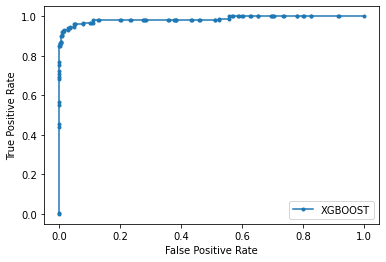

In [ ]:
# Let's print All the Predict_prob for All Models i test its


precision , recall,threshold=precision_recall_curve(Y_test,grid_searc_XGB.predict_proba(X_test)[:,1])
F1 = 2 * (precision * recall) / (precision + recall)
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = grid_searc_XGB.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)           ## No skill
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBOOT: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model

plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBOOST')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Best Threshold=0.839946, F-Score=0.934


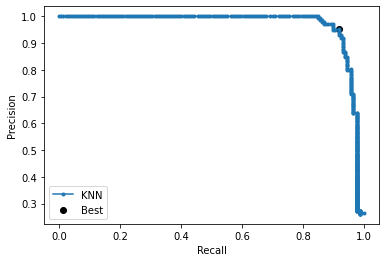

In [ ]:
#Precion Recall Curve
# optimal threshold for precision-recall curve with logistic regression model
yhat = grid_searc_XGB.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
i_arx = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i_arx], fscore[i_arx]))
# plot the roc curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',label='KNN')
plt.scatter(recall[i_arx], precision[i_arx], color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
from xgboost import XGBClassifier

# After Remove the less important features
# 180, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.05
xgb_grid = XGBClassifier(learning_rate=0.1,max_depth=8,n_estimators=180,objective= 'binary:logistic',gamma=0.05)

s=time.time()

xgb_grid.fit(X_train, Y_train)

e=time.time()

pred=xgb_grid.predict(X_test)

score = xgb_grid.score(X_test, Y_test)

print(score)



print("Accuracy",accuracy_score(Y_test,pred))

print("F1-Score",f1_score(Y_test,pred))

print("Precision",precision_score(Y_test,pred))

print("Recall",recall_score(Y_test,pred))

# print(xgb_grid.feature_importances_)

# print classification report

print(classification_report(Y_test, pred))

print(confusion_matrix(Y_test,pred))

print("Time ",(e-s))




# train

pred_train=xgb_grid.predict(X_train)

# print("Accuracy",accuracy_score(Y_train,pred_train))

# print("F1-Score",f1_score(Y_train,pred_train))

# print("Precision",precision_score(Y_train,pred_train))

# print("Recall",recall_score(Y_train,pred_train))

# print(xgb_grid.feature_importances_)

0.963718820861678
Accuracy 0.963718820861678
F1-Score 0.8961038961038961
Precision 0.8571428571428571
Recall 0.9387755102040817
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       735
         1.0       0.86      0.94      0.90       147

    accuracy                           0.96       882
   macro avg       0.92      0.95      0.94       882
weighted avg       0.97      0.96      0.96       882

[[712  23]
 [  9 138]]
Time  2.5568251609802246


In [ ]:
for col,score in zip(X_train.columns,xgb_grid.feature_importances_):
  print(col,score)

onehotencoder__x0_Non-Travel 0.025481878
onehotencoder__x0_Travel_Frequently 0.020097243
onehotencoder__x0_Travel_Rarely 0.0183464
onehotencoder__x1_Human Resources 0.012555474
onehotencoder__x1_Research & Development 0.013259223
onehotencoder__x1_Sales 0.018411575
onehotencoder__x2_Human Resources 0.029273545
onehotencoder__x2_Life Sciences 0.013998239
onehotencoder__x2_Marketing 0.02449355
onehotencoder__x2_Medical 0.0088790385
onehotencoder__x2_Other 0.0549948
onehotencoder__x2_Technical Degree 0.020838398
onehotencoder__x3_Healthcare Representative 0.019907316
onehotencoder__x3_Human Resources 0.04965898
onehotencoder__x3_Laboratory Technician 0.018027067
onehotencoder__x3_Manager 0.029464528
onehotencoder__x3_Manufacturing Director 0.021210494
onehotencoder__x3_Research Director 0.023066549
onehotencoder__x3_Research Scientist 0.020496782
onehotencoder__x3_Sales Executive 0.01514577
onehotencoder__x3_Sales Representative 0.029033683
onehotencoder__x4_Divorced 0.015647521
onehotenc

In [ ]:
X_test=X_test[['onehotencoder__x0_Travel_Frequently', 'onehotencoder__x1_Research & Development', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x4_Single', 'EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'DistanceFromHome', 'TotalWorkingYears', 'YearsAtCompany', 'Average hours worked', 'Is Loyal']]
X_train=X_train[['onehotencoder__x0_Travel_Frequently', 'onehotencoder__x1_Research & Development', 'onehotencoder__x2_Life Sciences', 'onehotencoder__x4_Single', 'EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'DistanceFromHome',  'TotalWorkingYears', 'YearsAtCompany', 'Average hours worked', 'Is Loyal']]

[0]	validation_0-error:0.088	validation_0-logloss:0.628179	validation_1-error:0.168934	validation_1-logloss:0.641087
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.07025	validation_0-logloss:0.575171	validation_1-error:0.150794	validation_1-logloss:0.597656
[2]	validation_0-error:0.0635	validation_0-logloss:0.528851	validation_1-error:0.136054	validation_1-logloss:0.561127
[3]	validation_0-error:0.06525	validation_0-logloss:0.489245	validation_1-error:0.134921	validation_1-logloss:0.529698
[4]	validation_0-error:0.0555	validation_0-logloss:0.450123	validation_1-error:0.126984	validation_1-logloss:0.500861
[5]	validation_0-error:0.054	validation_0-logloss:0.418868	validation_1-error:0.129252	validation_1-logloss:0.47608
[6]	validation_0-error:0.049	validation_0-logloss:0.387673	validation_1-error:0.124717	validation_1-logloss:0.453061
[7]	validat

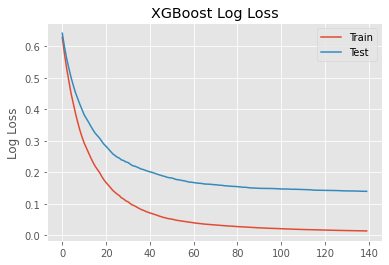

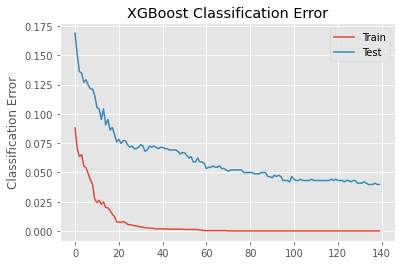

In [ ]:
from xgboost import XGBClassifier

# After Remove the less important features

xgb_grid = XGBClassifier(learning_rate=0.1,max_depth=9,n_estimators=140,objective= 'binary:logistic')

eval_set = [(X_train, Y_train), (X_test, Y_test)]
s=time.time()

# xgb_grid.fit(X_train, Y_train,Y_train.values.ravel())
xgb_grid.fit(X_train, Y_train.values.ravel(), early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
y_pred = xgb_grid.predict(X_test)

e=time.time()

y_pred = xgb_grid.predict(X_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
# score = xgb_grid.score(X_test, Y_test)
# print(score)
print("Accuracy",accuracy_score(Y_test,predictions))

print("F1-Score",f1_score(Y_test,predictions))

print("Precision",precision_score(Y_test,predictions))

print("Recall",recall_score(Y_test,predictions))

# print(xgb_grid.feature_importances_)

# print classification report

print(classification_report(Y_test, predictions))

print(confusion_matrix(Y_test,predictions))

print("Time ",(e-s))



print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = xgb_grid.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# train

# pred_train=xgb_grid.predict(X_train)

# print("Accuracy",accuracy_score(Y_train,pred_train))

# print("F1-Score",f1_score(Y_train,pred_train))

# print("Precision",precision_score(Y_train,pred_train))

# print("Recall",recall_score(Y_train,pred_train))

# print(xgb_grid.feature_importances_)

# 0.9682539682539683
# Accuracy 0.9682539682539683
# F1-Score 0.8999999999999999                              on the total data best 
# Precision 0.8811188811188811
# Recall 0.9197080291970803

# when using feature_importances_
# 0.9614512471655329
# Accuracy 0.9614512471655329
# F1-Score 0.8819444444444444                  when i select the important feature beacuse the XGBoost can get the features_important and i can select based on the score
# Precision 0.8410596026490066
# Recall 0.927007299270073